# PLUMMER SPHERE DATA ANALYSIS WITH PERTURBER


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import math
import scipy
from scipy.stats import norm
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.gridspec as gridspec

from tqdm import tqdm

import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import pandas as pd


rc = {"font.family" : "serif",
      "mathtext.fontset" : "cm",
      "font.size" : "14",
      "figure.figsize" : [10,5]}

plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

### parameters of the plummer

In [42]:
N = 10000
G_p = 6.67*10**(-8)*u.cm**3/(u.g*u.s**2)
G_iu = 1

# radius:
r_iu = 1*u.pc
r_p = r_iu.to(u.cm)

# mass:
M_iu = 1*u.M_sun
M_p = M_iu.to(u.g)

# scale factor :
scale_factor = 45

# my values:
m_points = 1*M_iu
R_halo = 2*scale_factor *r_iu



# the density of the cluster is given by:
rho_iu = N*(m_points/M_iu)/((4*np.pi*(R_halo/r_iu)**3)/3)
rho_p = N*M_p/((4*np.pi*(R_halo.to(u.cm))**3)/3)

# compute the collapse time:
cost = np.sqrt(3*np.pi/32)
tc_iu = cost/np.sqrt(G_iu*rho_iu)
tc_p = cost/np.sqrt(G_p*rho_p)

print("The mass of the stars - so my test particles - (in internal units) is: ", m_points/M_iu)
print("The radius of the cluster (in internal units) is: ", R_halo/r_iu)
print("The density of the cluster (in internal units) is: ", rho_iu)
print("The density of the cluster (in physical units) is: ", rho_p)
print("The collapse time (in internal units) is: ", tc_iu)
print("The collapse time (in physical units) is: ", tc_p)

The mass of the stars - so my test particles - (in internal units) is:  1.0
The radius of the cluster (in internal units) is:  90.0
The density of the cluster (in internal units) is:  0.003274793067734472
The density of the cluster (in physical units) is:  2.216348943565359e-25 g / cm3
The collapse time (in internal units) is:  9.48349988690498
The collapse time (in physical units) is:  4463531346157704.5 s


# Successful trials  

1000 bodies: ./treecode in=treecode_in_4.txt out=treecode_out_4.txt dtime=0.001 eps=%f theta=0.1 tstop=10 dtout=0.1

/Dynamics_experience3/treecode in=treecode_in_10000bodies_perturber.txt out=treecode_out_10000bodies_perturber.txt dtime=0.01 eps=0.5 theta=0.1 tstop=10 dtout=0.1


with $\textbf{one}$ repetition  

# Change the output file name here:

In [20]:
file_out_name = 'treecode_out_mpert100_2.txt'

# Reading from the output file (for gif)

In [31]:
file = open(file_out_name, "r")
firstrow = (file.readline()).strip("\n")
NL = 1
for line in file:
	NL += 1
file.close()

#								# More info below, at lines 94-101
I = int(firstrow)				# N_particles
L = 3+3*I						# N_lines for each timestep
NT = int(NL / L)				# N_timesteps	
X = np.zeros((I,4,NT))			# Empty array for the positions at each t	
V = np.zeros((I,4,NT))			# Empty array for the velocities at each t
#P = np.zeros((I,NT))			# Empty array for the potentials at each t
#K = np.zeros((I,NT))			# Empty array for the kinetic energies at each t
#E = np.zeros((I,NT))			# Empty array for the energies at each t
M = np.zeros((I,NT))			# Empty array for the masses at each t (should be const)
N = np.zeros(NT)				# Empty array for the N_particles at each t (should be const)
Time = np.zeros(NT)				# Empty array for the times t


file = open(file_out_name, "r")		# Read data
i = 0
t = 0
for line in file:
	l = line.strip("\n")
	j = i % L
	if j == 0:
		N[t] = float(l)
	elif j == 2:
		Time[t] = float(l)
	elif j >= 3 and j < (3+I): 
		m = j-3
		M[m,t] = float(l)
	elif j >= (3+I) and j < (3+2*I):
		m = j - (3+I)
		b = l.split()
		for k in range(len(b)):
			X[m,k+1,t] = float(b[k])
	elif j >= (3+2*I) and j < (3+3*I):
		m = j - (3+2*I)
		b = l.split()
		for k in range(len(b)):
			V[m,k+1,t] = float(b[k])
#	elif j >= (3+3*I) and j < (3+4*I):
#		m = j - (3+3*I)
#		P[m,t] = float(a)
		if (j+1) == (3+3*I):
			t += 1
	i += 1
file.close()
    
# fill the array
t_sim = Time

masses = M.T

x_sim = X.T[:,1,:]
y_sim = X.T[:,2,:]
z_sim = X.T[:,3,:]
r_sim = np.sqrt(x_sim**2+y_sim**2+z_sim**2)

Vx_sim = V.T[:,1,:]
Vy_sim = V.T[:,2,:]
Vz_sim = V.T[:,3,:]
Vr_sim = np.sqrt(Vx_sim**2+Vy_sim**2+Vz_sim**2)

In [32]:
#PERTURBER INDEX
pert_idx = 0

# Animation

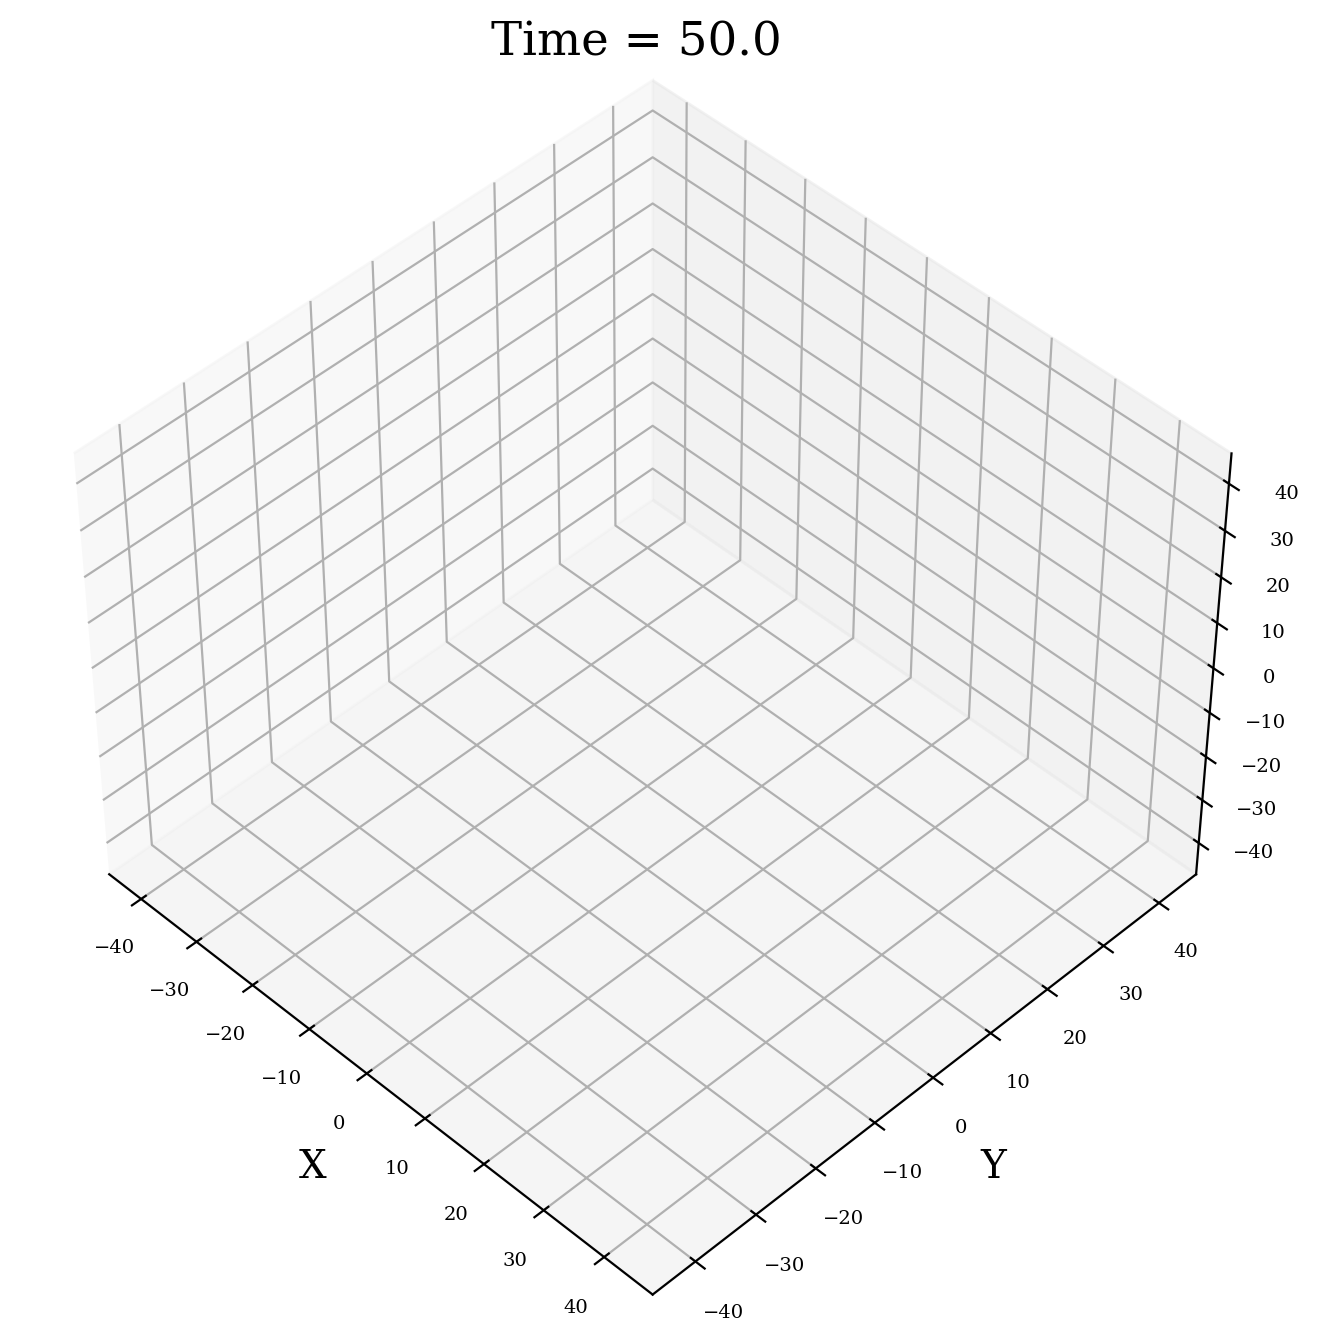

In [46]:
#plot------------------------------------------------------------------------------

fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(projection='3d')
ax.set_aspect('auto')

# compute the center of mass for visualization:
mask_COM_0 = r_sim[0,:]<(10*2*scale_factor)

com_x_sim_0 = np.sum(x_sim[0,mask_COM_0]*masses[0,mask_COM_0])/(np.sum(masses[0,mask_COM_0]))
com_y_sim_0 = np.sum(y_sim[0,mask_COM_0]*masses[0,mask_COM_0])/(np.sum(masses[0,mask_COM_0]))
com_z_sim_0 = np.sum(z_sim[0,mask_COM_0]*masses[0,mask_COM_0])/(np.sum(masses[0,mask_COM_0]))

ax.view_init(elev=45, azim=-45)
ax.set_xlim(com_x_sim_0-45,com_x_sim_0+45)
ax.set_ylim(com_y_sim_0-45,com_y_sim_0+45)
ax.set_zlim(com_z_sim_0-45,com_z_sim_0+45)

ax.set_xlabel(r'X')
ax.set_ylabel(r'Y')
ax.set_zlabel(r'Z')
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='z', labelsize=7)


#animation--------------------------------------------------------------------------------
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

scatters, = ax.plot([], [], [], 'o', markersize='1',alpha=0.5)
#scatter_BH, = ax.plot([], [], [], 'o', markersize='3',color='black')
scatter_pert, = ax.plot([], [], [], 'o', markersize='3',color='red')

def init():
    scatters.set_data([],[])
    scatters.set_3d_properties([])
    
    #scatter_BH.set_data([],[])
    #scatter_BH.set_3d_properties([])
    
    scatter_pert.set_data([],[])
    scatter_pert.set_3d_properties([])
    
    #return scatters, scatter_BH, scatter_pert
    return scatters, scatter_pert

def animate_time(i): 
    # plot the Plummer sphere
    scatters.set_data(x_sim[i,:-1], y_sim[i,:-1]) 
    scatters.set_3d_properties(z_sim[i,:-1])
    
    # plot the perturber
    #scatter_BH.set_data(np.array([x_sim[i,-2]]), np.array([y_sim[i,-2]]))
    #scatter_BH.set_3d_properties(np.array([z_sim[i,-2]]))
    
    scatter_pert.set_data(np.array([x_sim[i,-1]]), np.array([y_sim[i,-1]]))
    scatter_pert.set_3d_properties(np.array([z_sim[i,-1]]))
    
    ax.set_title('Time = %.1f'%(t_sim[i]))
        
    #return scatters, scatter_BH, scatter_pert
    return scatters, scatter_pert


num_frames = len(t_sim)
animazione = FuncAnimation(fig, animate_time, frames=num_frames, interval=100, init_func=init)

# save gif ----------------------------------------------------------------------------------------

animazione.save('pertuber_M100.gif', writer = 'ffmpeg')

plt.rcParams['animation.html'] = 'html5'

#animazione

# save mp4 ----------------------------------------------------------------------------------------

mywriter = FFMpegWriter()
animazione.save('pertuber_M100.mp4',writer=mywriter)

In [47]:
filename = file_out_name

N = 10000 +1 #BECAUSE OF THE PERTURBER

# Counting the number of steps 

n_outputs = 0

with open(filename, "r") as file:
    for line in file:
        if line.strip() == str(N):
            n_outputs += 1
            
print(n_outputs) 

101


In [48]:
# Reading times

data_time = np.empty(n_outputs)
with open(filename, "r") as file:
    index = 0
    for _ in range(n_outputs):
        for i in range(2):
            file.readline()
        
        data_iter_t = np.genfromtxt(file, max_rows=1)
        data_time[index] = data_iter_t
        index += 1
        
        for _ in range(3*N):
            file.readline()

print(data_time.shape)

(101,)


In [49]:
# Reading masses from the output

#data_mass = np.empty(N*n_outputs)
data_mass = []

with open(filename, "r") as file:
    index = 0
    for _ in range(n_outputs):
        for i in range(3):
            file.readline()
        
        data_iter_m = np.genfromtxt(file, max_rows=N)
        data_mass[index:index+N] = data_iter_m
        index += N
        
        for _ in range(2*N):
            file.readline()
print(len(data_mass))

1010101


In [50]:
# Reading coordinates and velocities from the output

data_coordinates = []
data_velocities = []

with open(filename, "r") as file:
    for _ in range(n_outputs):
        for _ in range(3+N):
            file.readline()
            
        data_iter_c = np.genfromtxt(file, usecols = range(0,3), delimiter = '', max_rows=N)
        data_coordinates.append(data_iter_c)
        data_iter_v = np.genfromtxt(file, usecols = range(0,3), delimiter = '', max_rows=N)
        data_velocities.append(data_iter_v)
        
data_coordinates = np.concatenate(data_coordinates)
data_velocities = np.concatenate(data_velocities)

print(data_velocities.shape)

(1010101, 3)


In [51]:
x = np.zeros(shape = len(data_coordinates))
y = np.zeros(shape = len(data_coordinates))
z = np.zeros(shape = len(data_coordinates))

vx = np.zeros(shape = len(data_velocities))
vy = np.zeros(shape = len(data_velocities))
vz = np.zeros(shape = len(data_velocities))

for i in range(len(data_coordinates)):
    x[i] = data_coordinates[i][0]
    y[i] = data_coordinates[i][1]
    z[i] = data_coordinates[i][2]
    
for i in range(len(data_velocities)):
    vx[i] = data_velocities[i][0]
    vy[i] = data_velocities[i][1]
    vz[i] = data_velocities[i][2]

# 3D Plot

In [52]:
print(x.shape, y.shape, z.shape, n_outputs)
x_evolution = np.empty((N, n_outputs))
y_evolution = np.empty((N, n_outputs))
z_evolution = np.empty((N, n_outputs))
v_x_evolution = np.empty((N, n_outputs))
v_y_evolution = np.empty((N, n_outputs))
v_z_evolution = np.empty((N, n_outputs))

t = 0
n = 0
for t in range(n_outputs):
    
    for n in range(N):
        #print(n)
        x_evolution[n][t] = x[n + t*N]
        y_evolution[n][t] = y[n + t*N]
        z_evolution[n][t] = z[n + t*N]
        v_x_evolution[n][t] = vx[n + t*N]
        v_y_evolution[n][t] = vy[n + t*N]
        v_z_evolution[n][t] = vz[n + t*N]
        
print(x.shape)

(1010101,) (1010101,) (1010101,) 101
(1010101,)


[ 8.0000000e+00  7.9078317e+00  7.6872587e+00  7.4764395e+00
  7.3604717e+00  7.0858741e+00  6.5647054e+00  5.8753967e+00
  5.0181255e+00  4.0853877e+00  3.0860987e+00  1.9637222e+00
  8.2432133e-01 -2.5973746e-01 -1.2488009e+00 -2.1282613e+00
 -2.8514898e+00 -3.3539948e+00 -3.6914577e+00 -3.8903797e+00
 -3.8932655e+00 -3.6664808e+00 -3.4503713e+00 -3.3148949e+00
 -3.1078503e+00 -2.7316265e+00 -2.2457721e+00 -1.7860973e+00
 -1.4045353e+00 -8.5194498e-01 -1.5222618e-01  5.6941855e-01
  1.2669822e+00  1.9340070e+00  2.5657992e+00  3.0879717e+00
  3.4366264e+00  3.6287415e+00  3.6339314e+00  3.7194474e+00
  3.7074034e+00  3.5802205e+00  3.4051590e+00  3.2023149e+00
  3.0004487e+00  2.8932295e+00  2.4159214e+00  1.9413884e+00
  1.6609621e+00  1.5560615e+00  1.5513173e+00  1.2584802e+00
  1.0677834e+00  8.4596008e-01  6.3508087e-01  5.3244889e-01
  5.4366136e-01  5.4964387e-01  4.8225340e-01  3.4268019e-01
  2.2449271e-01  1.7714038e-01 -6.8112258e-03 -6.1958176e-01
 -1.2905363e+00 -1.94673

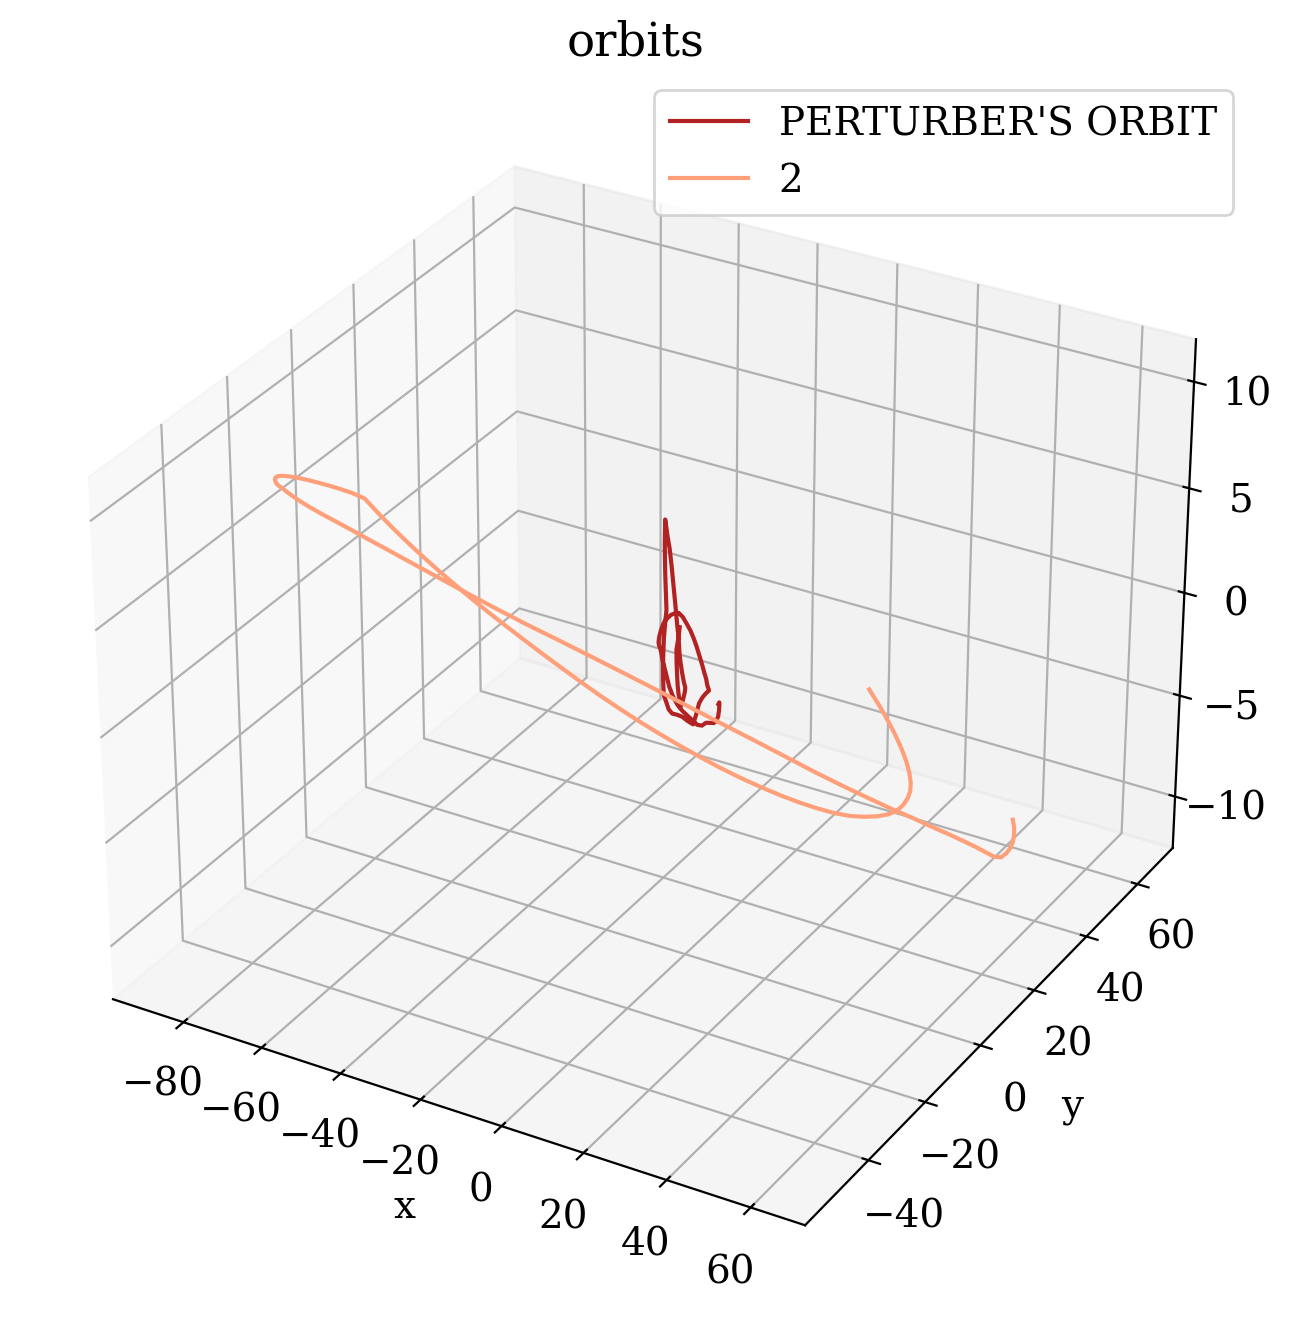

In [53]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

#IF I WANT POINTS:

#ax.scatter(x_evolution[0][:],y_evolution[0][:],z_evolution[0][:], color = 'lightseagreen')
#ax.scatter(x_evolution[1][:],y_evolution[1][:], z_evolution[1][:], color = 'coral')

#IF I WANT THE PLOT OF THE ORBITS
ax.plot(x_evolution[0], y_evolution[0], z_evolution[0], label='PERTURBER\'S ORBIT', color = 'firebrick')

print(x_evolution[0], y_evolution[0], z_evolution[0])
ax.plot(x_evolution[1], y_evolution[1], z_evolution[1], label='2', color = 'lightsalmon')
#plt.plot(x3, y3, label='3', color = 'blue')


ax.set_title('orbits')
ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.gca().set_aspect('equal', adjustable='box')
#ax.grid(True)
ax.legend()
#ax.set_xlim(-5,5)
#ax.set_ylim(-5,5)
#ax.set_zlim(-5,5)

plt.show()

/home/malvi/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


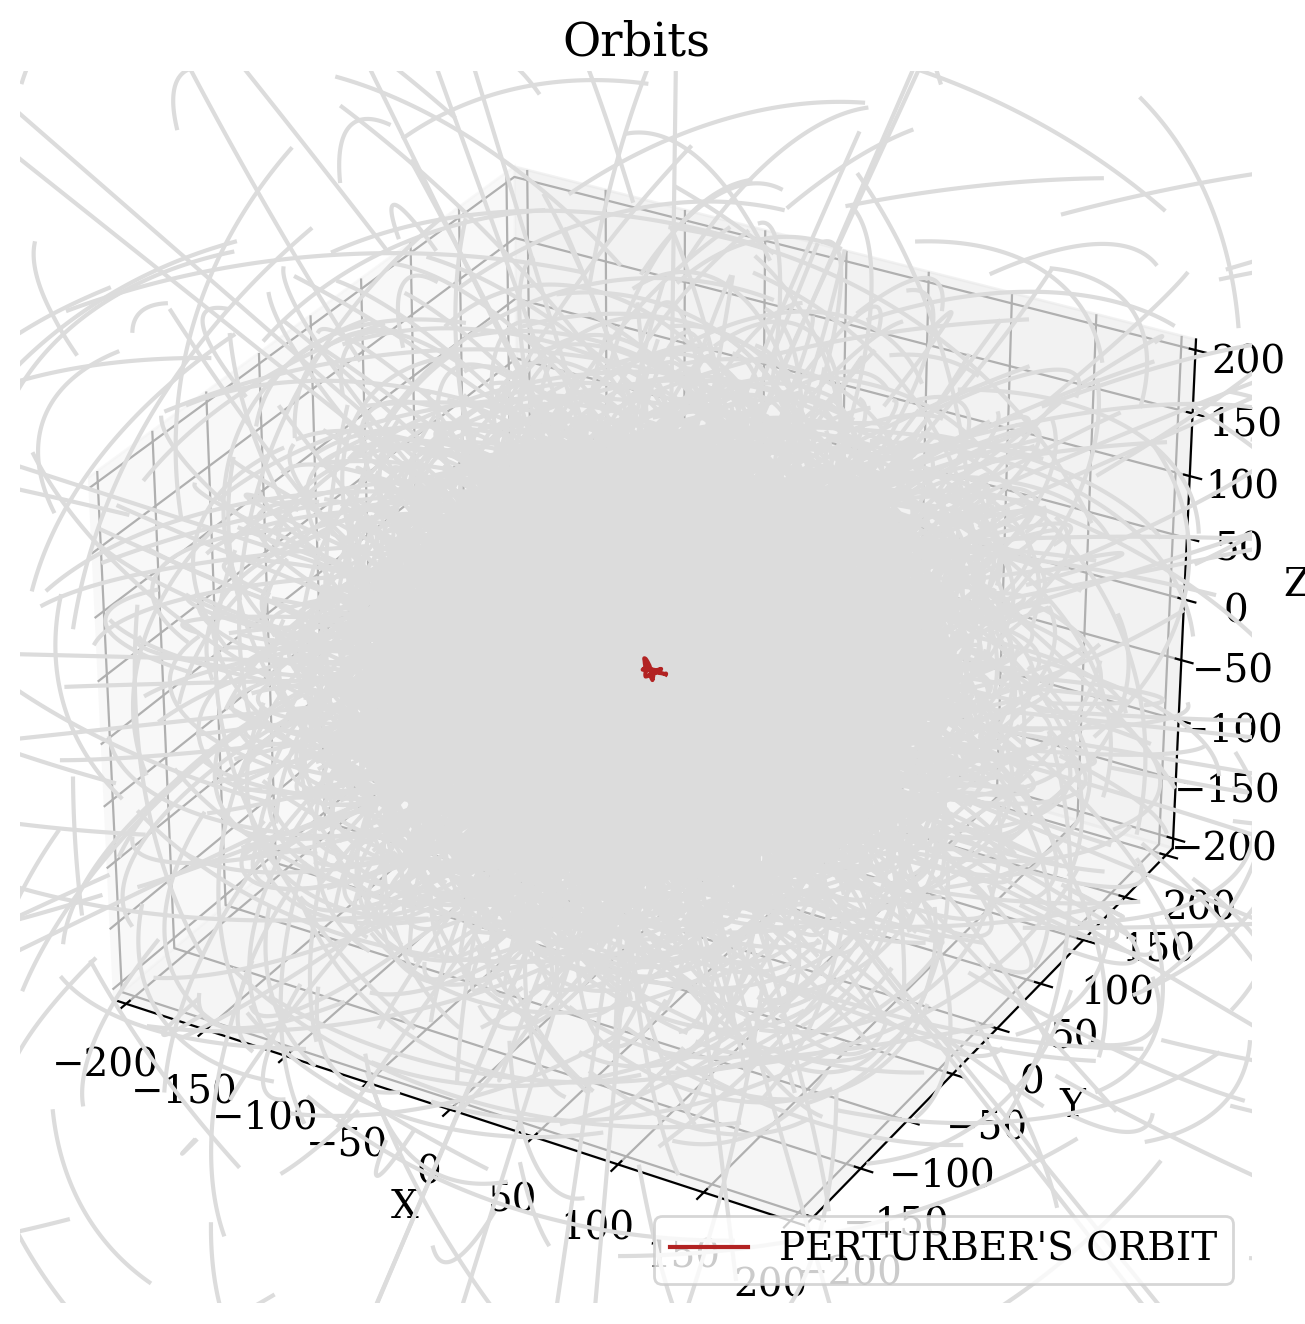

"\nplt.figure(figsize=(10, 8))\n\nfor n in range(n_bodies):\n    #IF I WANT POINTS:\n    #plt.scatter(x[n][:],y[n][:])\n    #IF I WANT THE PLOT OF THE ORBITS\n    plt.plot(x[n], y[n])\n\nplt.title('orbits')\nplt.xlabel('x')\nplt.ylabel('y')\n#plt.gca().set_aspect('equal', adjustable='box')\nplt.grid(True)\n#plt.legend()\nplt.show()\n"

In [54]:
#ALL THE ORBITS


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for orbit_x, orbit_y, orbit_z in zip(x_evolution, y_evolution, z_evolution):
    ax.plot(orbit_x, orbit_y, orbit_z, c = "gainsboro")

ax.plot(x_evolution[0], y_evolution[0], z_evolution[0], label='PERTURBER\'S ORBIT', color = 'firebrick')

ax.set_title('Orbits')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-200,200)
ax.set_ylim(-200,200)
ax.set_zlim(-200,200)
plt.legend()
plt.show()


'''
plt.figure(figsize=(10, 8))

for n in range(n_bodies):
    #IF I WANT POINTS:
    #plt.scatter(x[n][:],y[n][:])
    #IF I WANT THE PLOT OF THE ORBITS
    plt.plot(x[n], y[n])

plt.title('orbits')
plt.xlabel('x')
plt.ylabel('y')
#plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
#plt.legend()
plt.show()
'''

Text(0, 0.5, 'Perturber position')

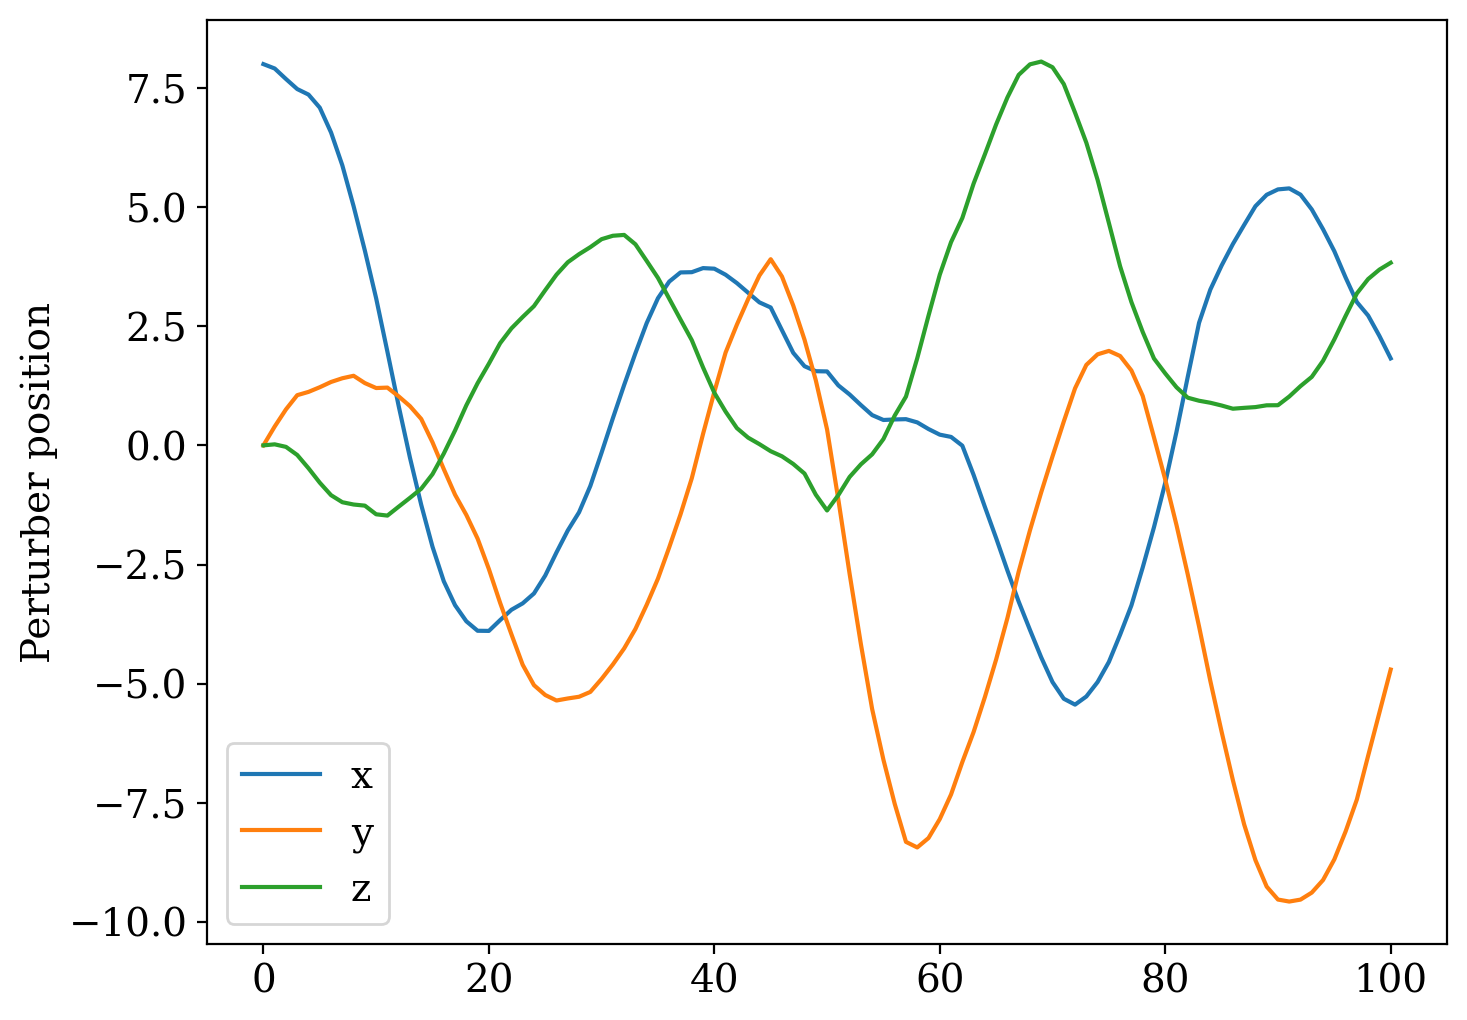

In [56]:
xp = np.zeros(shape=n_outputs)
yp = np.zeros(shape=n_outputs)
zp = np.zeros(shape=n_outputs)

for i in range(n_outputs):
    xp[i] = x[i*N]
    yp[i] = y[i*N]
    zp[i] = z[i*N]

plt.figure(figsize=(8,6))
plt.plot(xp, label = 'x')
plt.plot(yp, label = 'y')
plt.plot(zp, label = 'z')
plt.legend()
plt.ylabel('Perturber position')

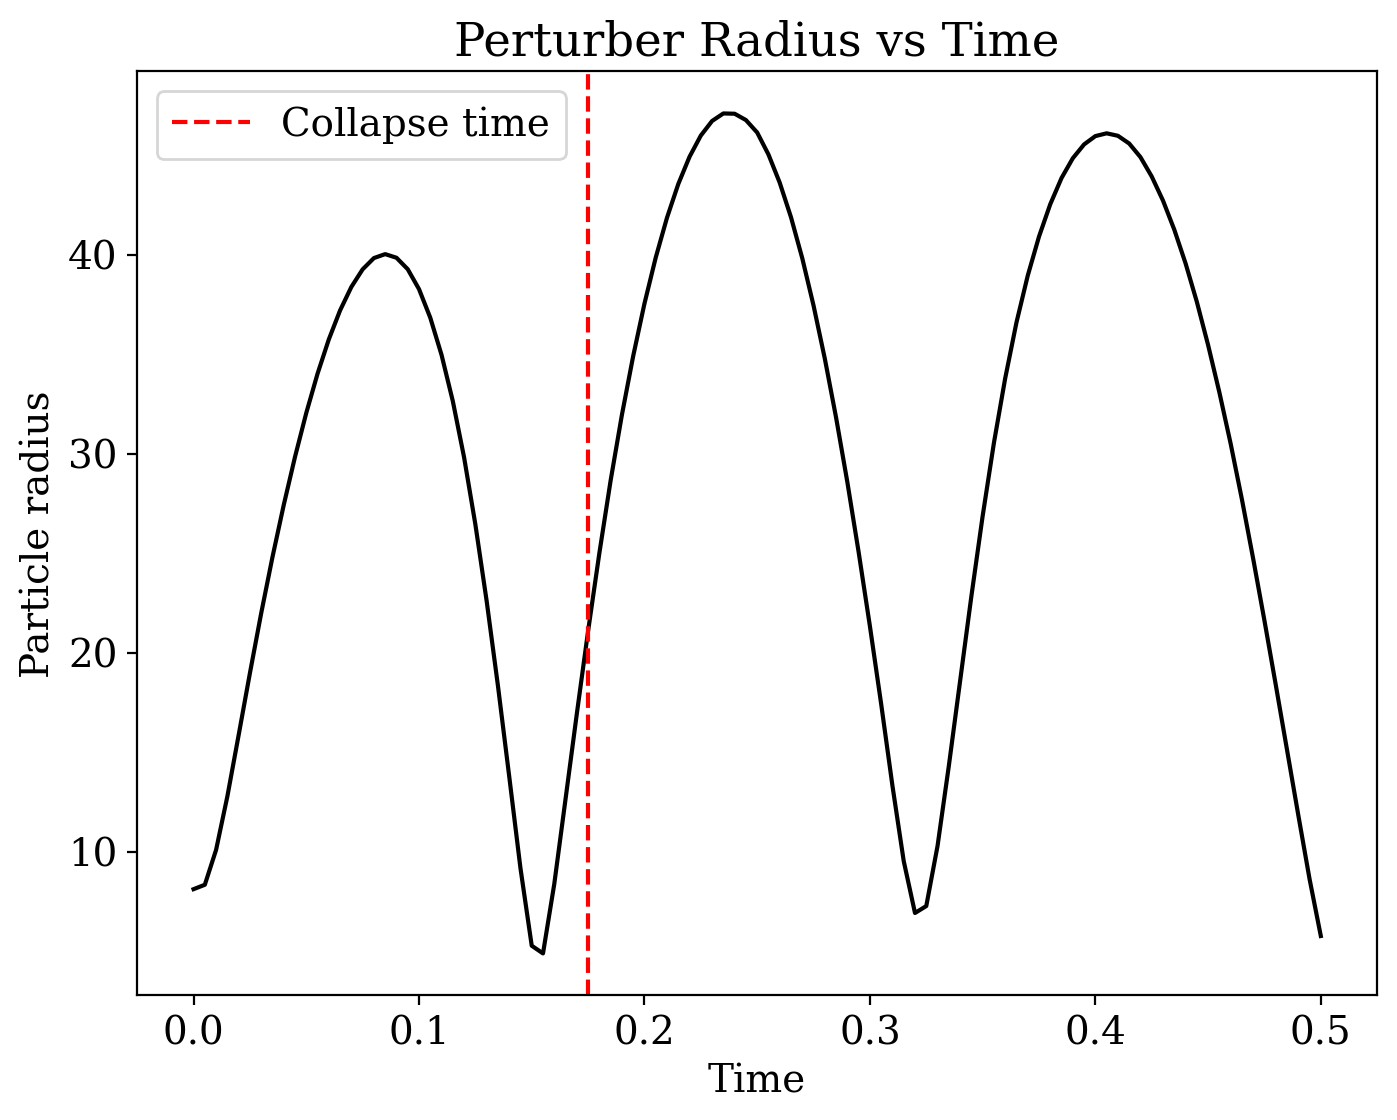

In [60]:
r_perturber = np.zeros(n_outputs)
for i in range(n_outputs):
    r_perturber[i] = np.sqrt(x[i*N]**2 + y[100+i*N]**2 + z[i*N]**2)

time = np.linspace(0, 0.5, len(r_perturber))
plt.figure(figsize=(8,6))
plt.plot(time, r_perturber, color='black')
plt.axvline(0.175, color='red', linestyle='dashed', label='Collapse time')
plt.xlabel('Time')
plt.ylabel('Particle radius')
plt.title('Perturber Radius vs Time')
plt.legend()
plt.show()

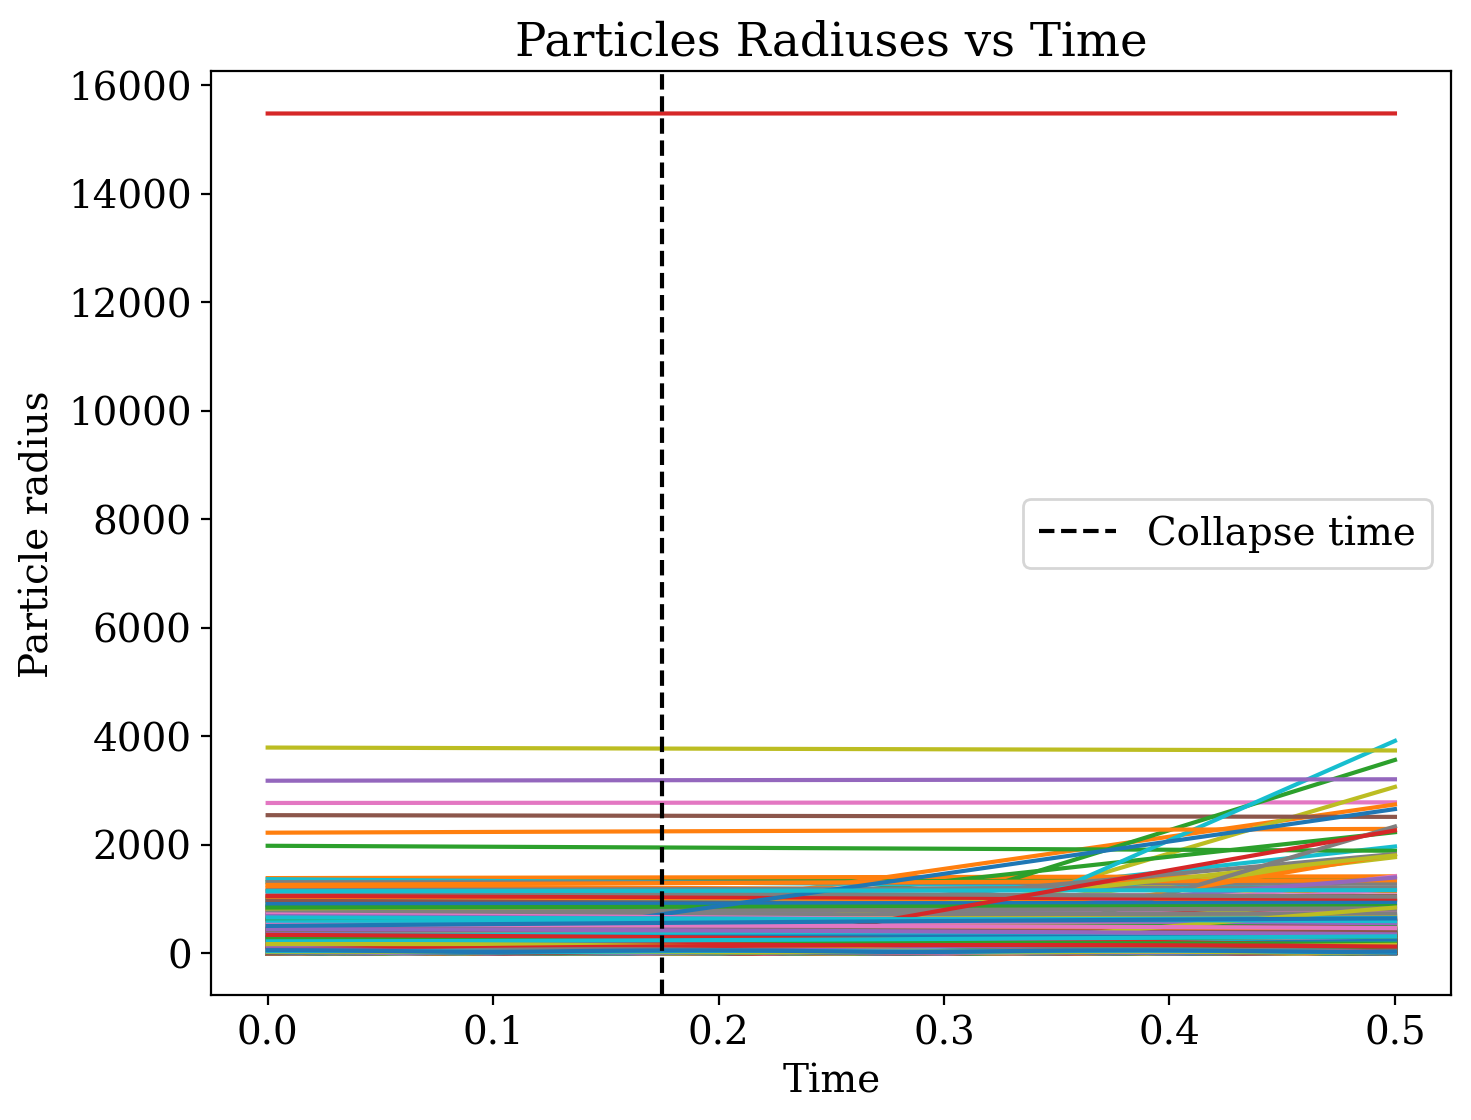

In [61]:
r_ptot = []
for j in range(N):
    r_part = np.zeros(n_outputs)
    
    for i in range(n_outputs):
        r_part[i] = np.sqrt(x[j+i*N]**2 + y[j+i*N]**2 + z[j+i*N]**2)
    r_ptot.append(r_part)

time = np.linspace(0, 0.5, n_outputs)
plt.figure(figsize=(8,6))
for i in range(N):
    plt.plot(time, r_ptot[i])
plt.axvline(0.175, color='black', linestyle='dashed', label='Collapse time')
plt.xlabel('Time')
plt.ylabel('Particle radius')
plt.title('Particles Radiuses vs Time')
plt.legend()
plt.show()

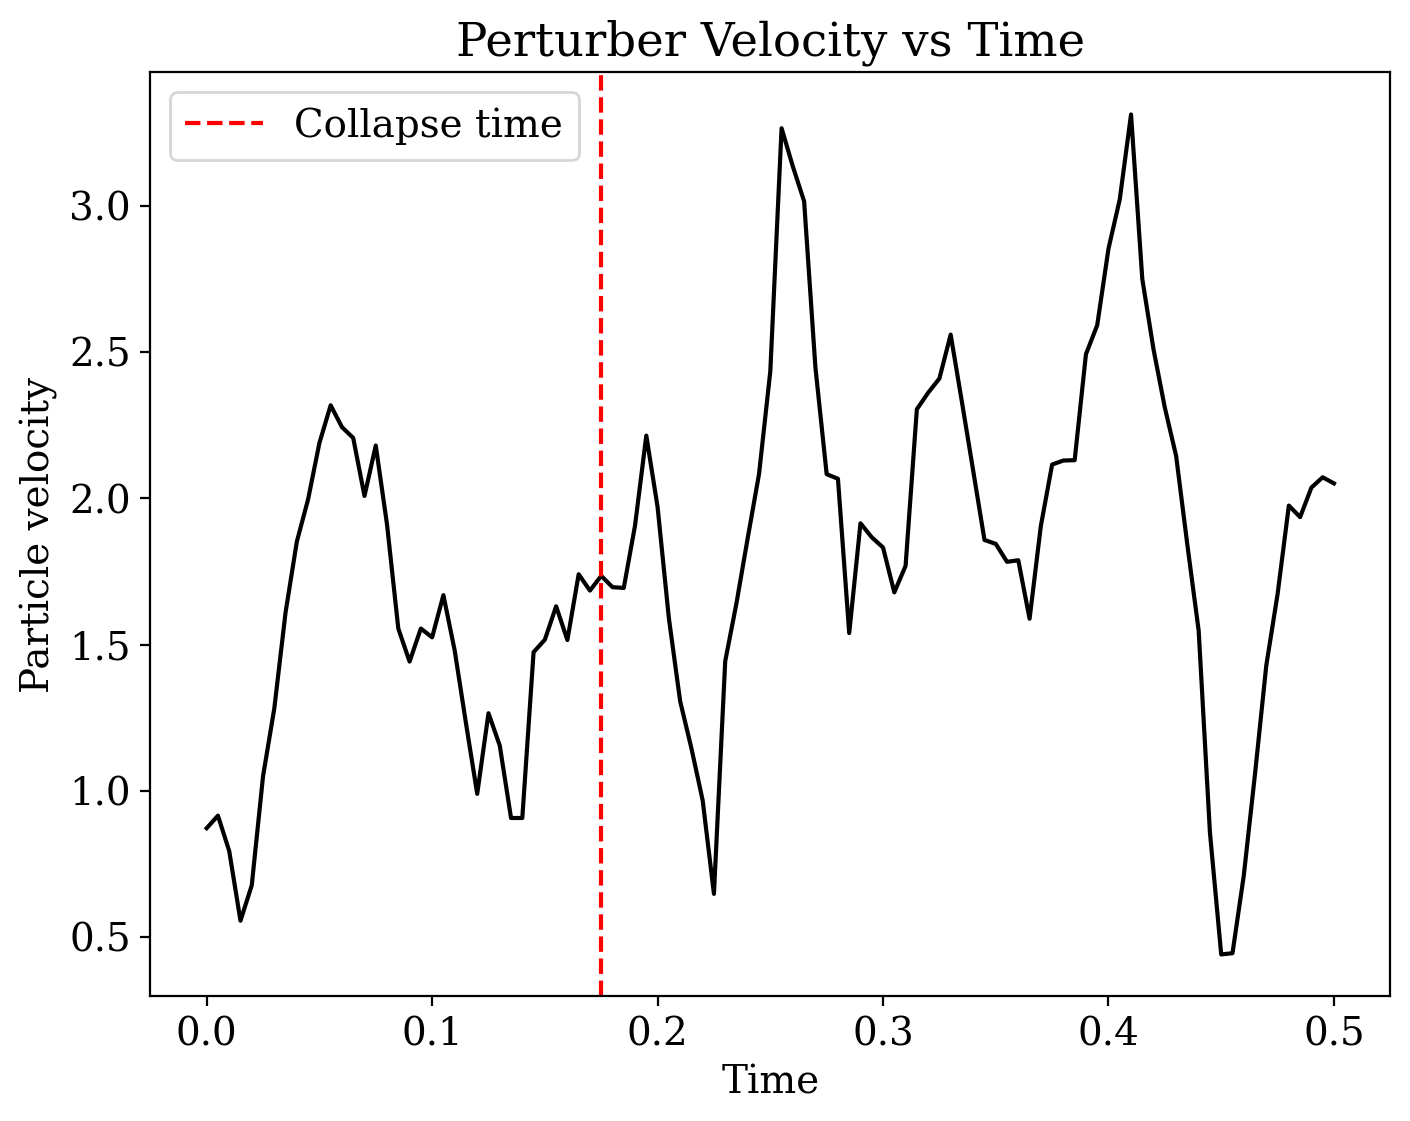

In [66]:
v_pert = np.zeros(n_outputs)
for i in range(n_outputs):
    v_pert[i] = np.sqrt(vx[i*N]**2 + vy[i*N]**2 + vz[i*N]**2)
    
time = np.linspace(0, 0.5, len(v_pert))
plt.figure(figsize=(8,6))
plt.plot(time, v_pert, color='black')
plt.axvline(0.175, color='red', linestyle='dashed', label='Collapse time')
plt.xlabel('Time')
plt.ylabel('Particle velocity')
plt.title('Perturber Velocity vs Time')
plt.legend()
plt.show()

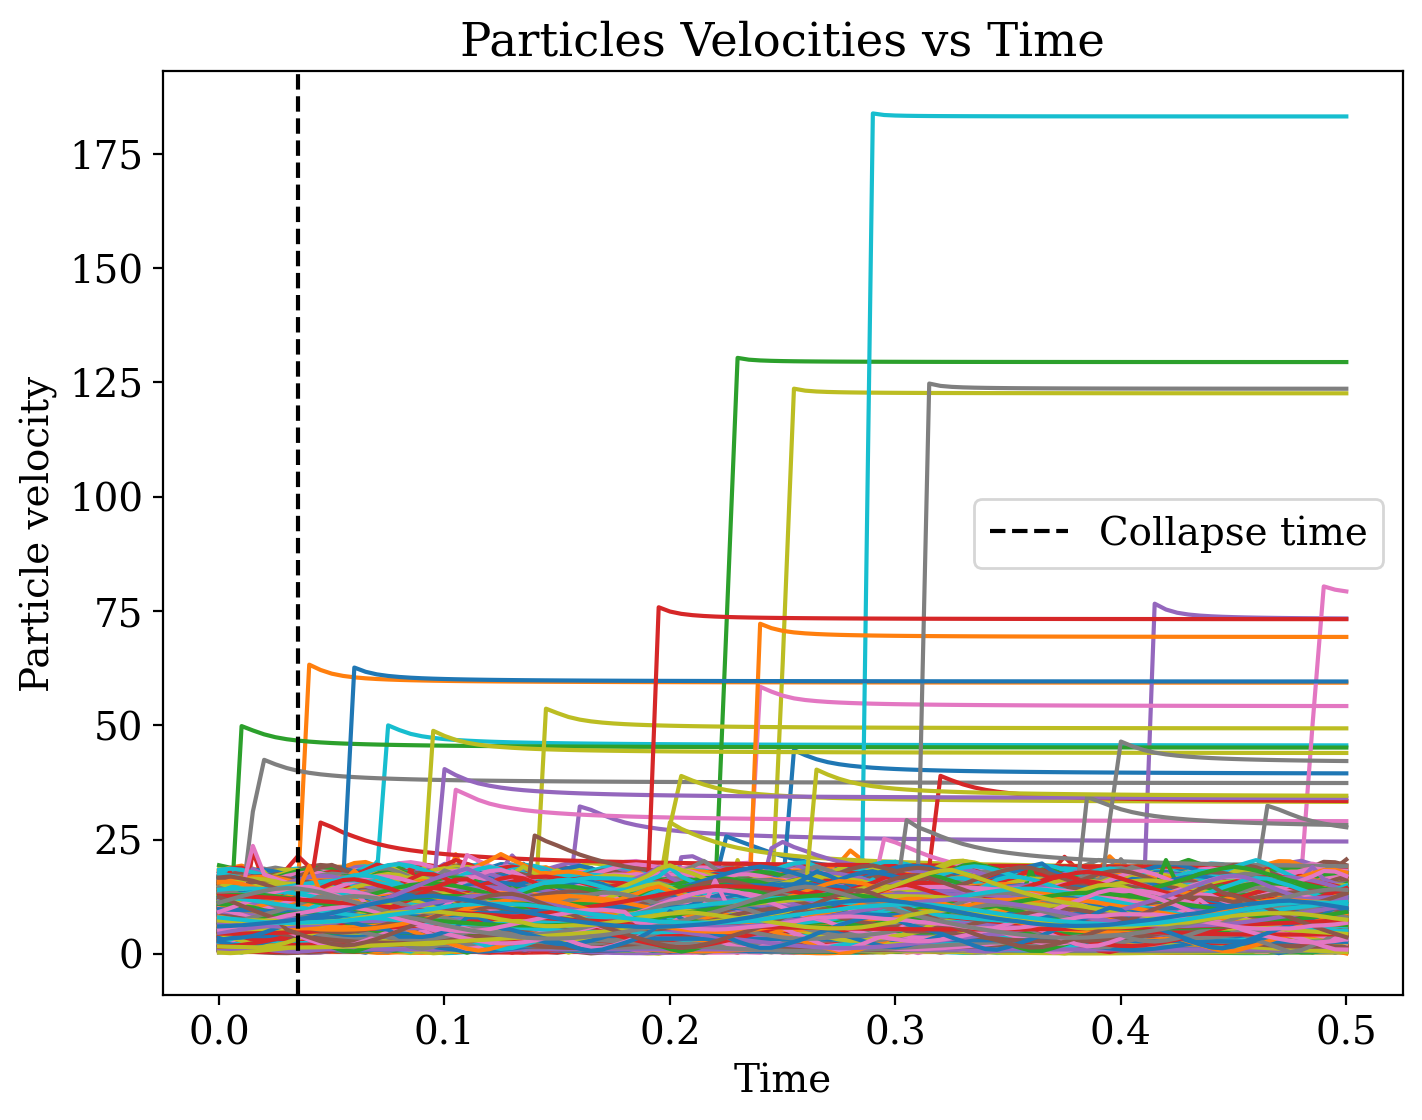

In [67]:
v_ptot = []
for j in range(N):
    v_p = np.zeros(n_outputs)
    
    for i in range(n_outputs):
        v_p[i] = np.sqrt(vx[j+i*N]**2 + vy[j+i*N]**2 + vz[j+i*N]**2)
    
    #r_p.sort()
    #r_p = r_p[::-1]
    v_ptot.append(v_p)

time = np.linspace(0, 0.5, n_outputs)
plt.figure(figsize=(8,6))
for i in range(N):
    plt.plot(time, v_ptot[i])
plt.axvline(0.035, color='black', linestyle='dashed', label='Collapse time')
plt.xlabel('Time')
plt.ylabel('Particle velocity')
#plt.ylim(0,1000)
plt.title('Particles Velocities vs Time')
plt.legend()
plt.show()

## velocities distribution at different times

[  0  50  75 100]


(-69.8737544,
 91.16929040000002,
 -156.8233005,
 118.57447049999999,
 -119.72162025,
 52.48162525000001)

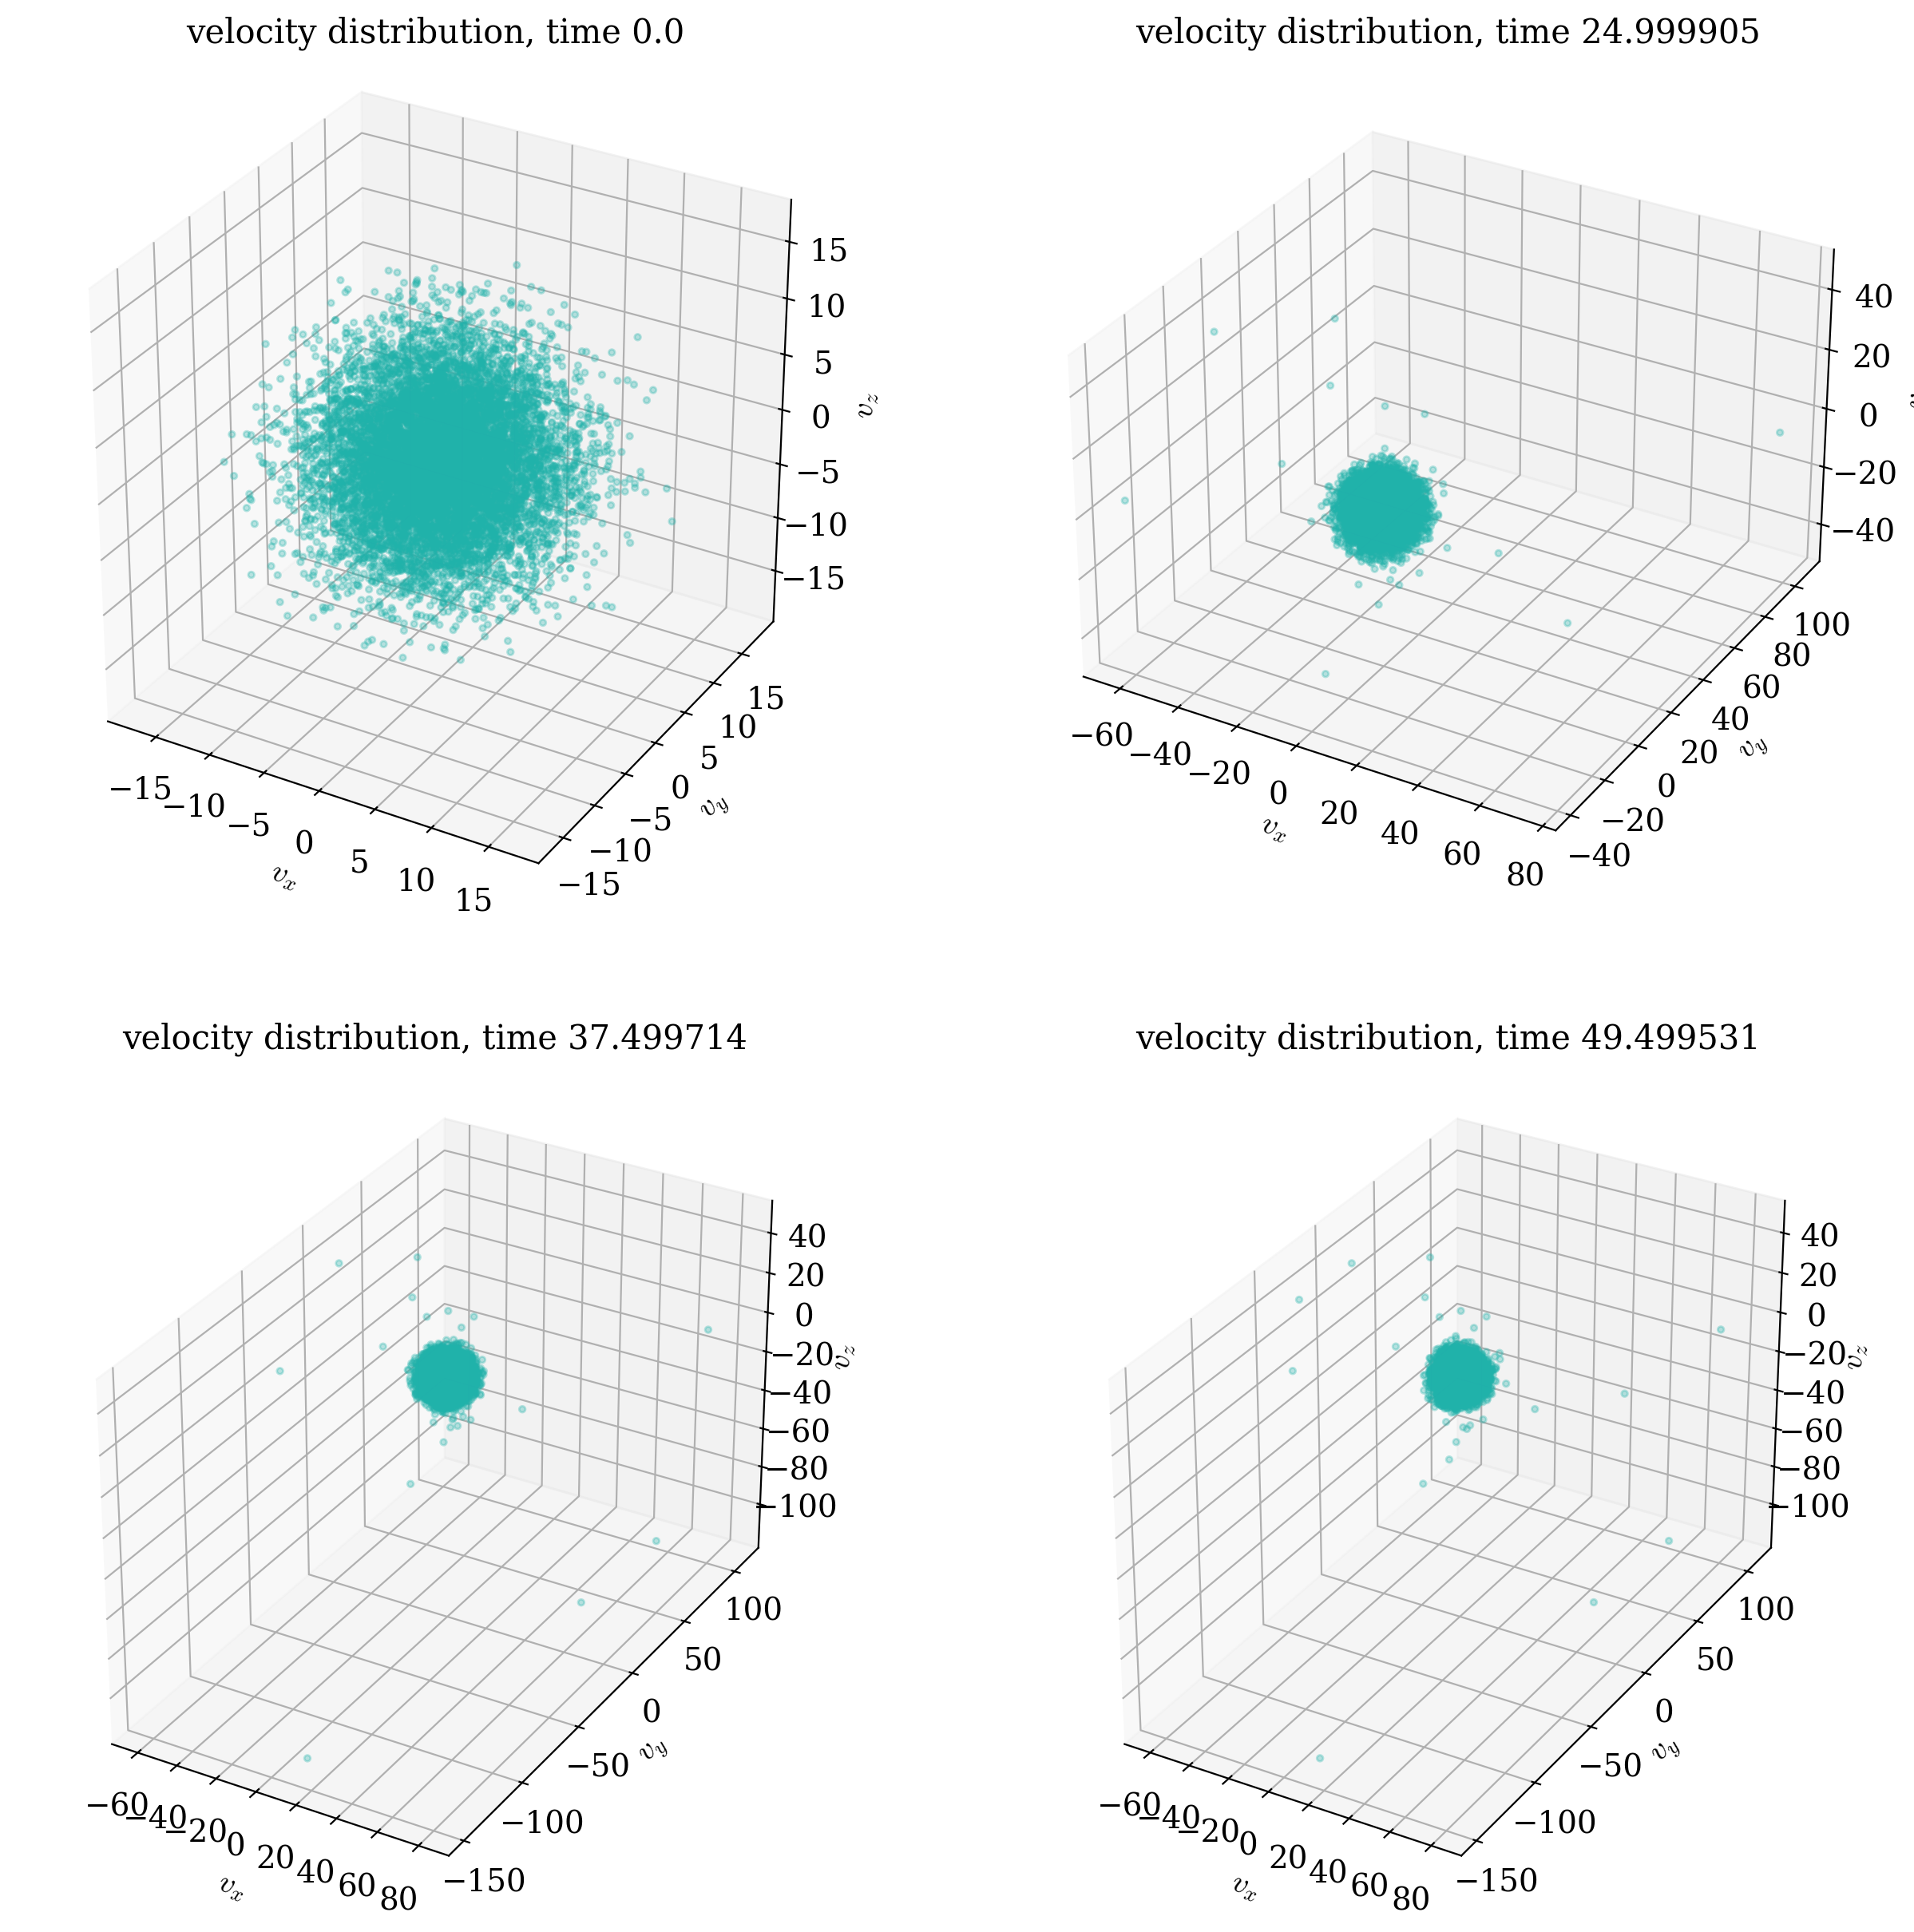

In [68]:
time_indexes = np.array((0, 2*len(data_time)/4, 3*len(data_time)/4, 4*len(data_time)/4-1), dtype = int)
print(time_indexes)
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)
#fig.title("Homogeneus galaxy at time zero")
ax0 = fig.add_subplot(gs[0,0], projection='3d')
ax1 = fig.add_subplot(gs[0,1], projection='3d')
ax2 = fig.add_subplot(gs[1,0], projection = '3d')
ax3 = fig.add_subplot(gs[1,1], projection = '3d')


ax0.scatter(vx[time_indexes[0]*N : time_indexes[0]*1+N], vy[time_indexes[0]*N:time_indexes[0]*1+N], vz[time_indexes[0]*N:time_indexes[0]*1+N], c = 'lightseagreen', s=7.5, alpha=0.3)
ax0.set_aspect('equal')
ax0.set_xlabel('$v_x$')
ax0.set_ylabel('$v_y$')
ax0.set_zlabel('$v_z$')
ax0.set_title('velocity distribution, time ' + str(data_time[time_indexes[0]]), fontsize=15)
ax0.axis('equal')



ax1.scatter(vx[time_indexes[1]*N:time_indexes[1]*N+N], vy[time_indexes[1]*N:time_indexes[1]*N+N], vz[time_indexes[1]*N:time_indexes[1]*N+N], c = 'lightseagreen', s=7.5, alpha=0.3)
ax1.set_aspect('equal')
ax1.set_xlabel('$v_x$')
ax1.set_ylabel('$v_y$')
ax1.set_zlabel('$v_z$')
ax1.set_title('velocity distribution, time ' + str(data_time[time_indexes[1]]),fontsize=15)
ax1.axis('equal')


ax2.scatter(vx[time_indexes[2]*N:time_indexes[2]*N+N], vy[time_indexes[2]*N:time_indexes[2]*N+N], vz[time_indexes[2]*N:time_indexes[2]*N+N], c = 'lightseagreen', s=7.5, alpha=0.3)
ax2.set_aspect('equal')
ax2.set_xlabel('$v_x$')
ax2.set_ylabel('$v_y$')
ax2.set_zlabel('$v_z$')
ax2.set_title('velocity distribution, time ' + str(data_time[time_indexes[2]]), fontsize=15)
ax2.axis('equal')


ax3.scatter(vx[time_indexes[3]*N:time_indexes[3]*N+N], vy[time_indexes[3]*N:time_indexes[3]*N+N], vz[time_indexes[3]*N:time_indexes[3]*N+N], c = 'lightseagreen', s=7.5, alpha=0.3)
ax3.set_aspect('equal')
ax3.set_xlabel('$v_x$')
ax3.set_ylabel('$v_y$')
ax3.set_zlabel('$v_z$')
ax3.set_title('velocity distribution, time ' + str(data_time[time_indexes[3]-1]), fontsize=15)
ax3.axis('equal')

#ax.set_xlim(-13, 13)
#ax.set_ylim(-13, 13)
#ax.set_zlim(-13, 13)

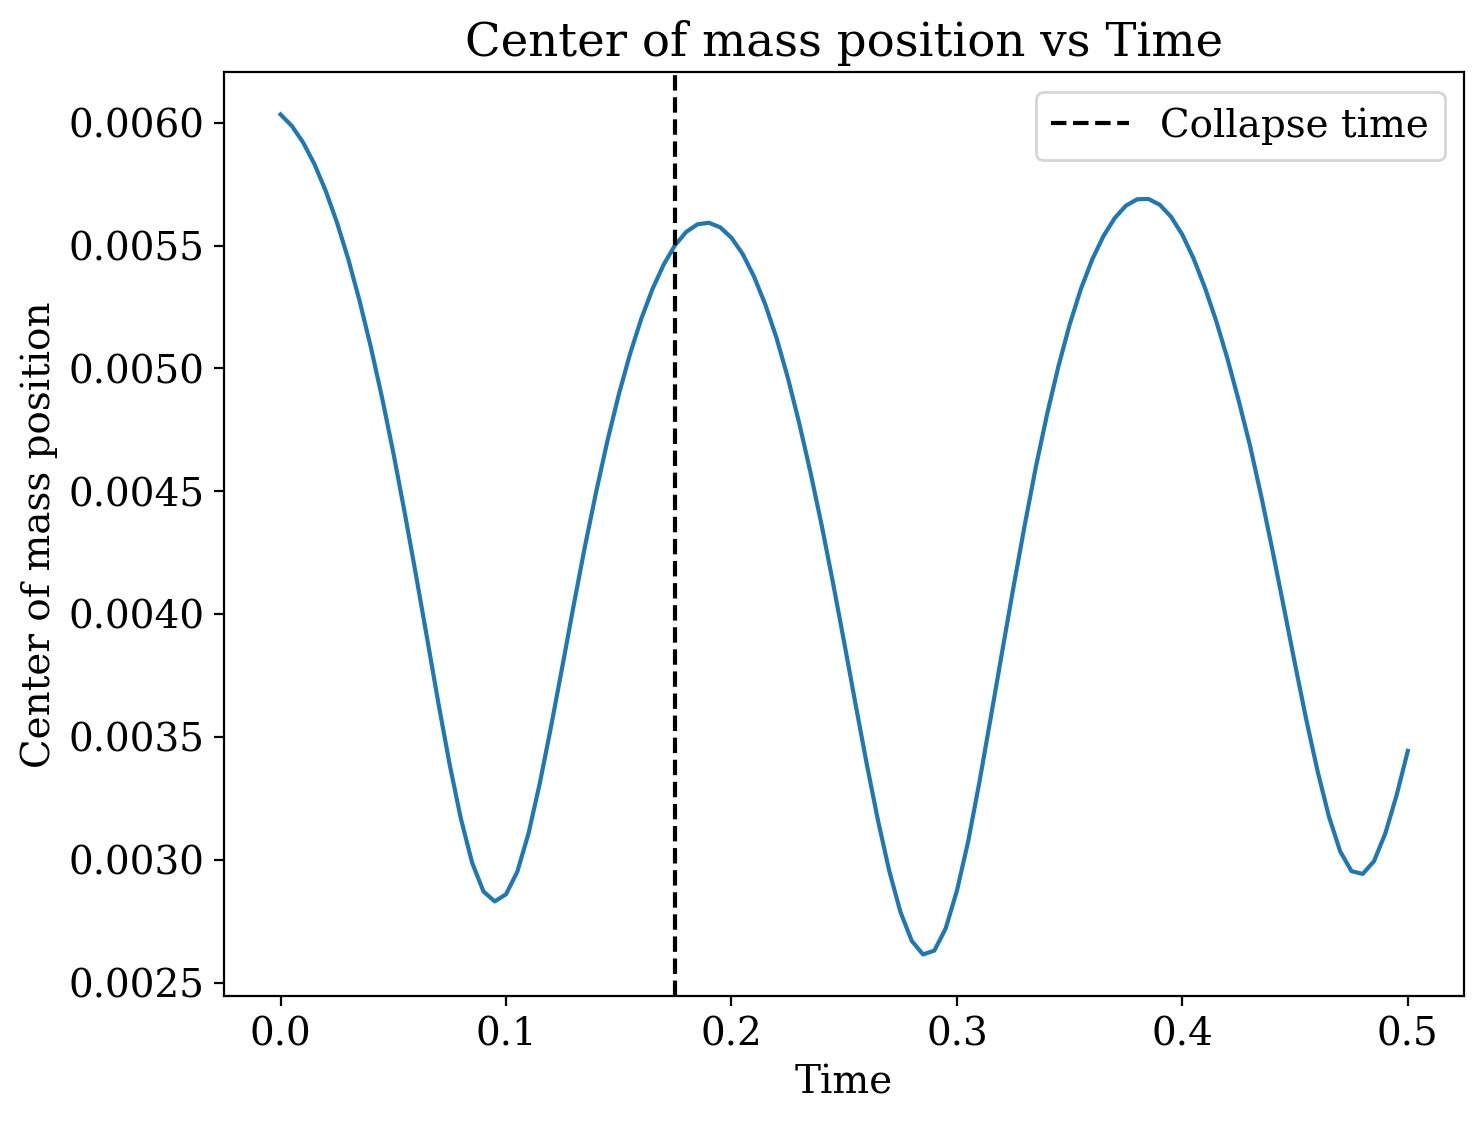

In [69]:
# Center of mass' motion
m=1
r_com = []
for j in range(N):
    r_com_ndx = np.zeros(n_outputs)
    
    for i in range(n_outputs):
        r_com_ndx[i] += r_part[i]*m / (m*N)
    
    r_com.append(r_com_ndx)

time = np.linspace(0, 0.5, n_outputs)
#for i in range(N):
    #plt.plot(time, r_com[i])
plt.figure(figsize=(8,6))
plt.plot(time, r_com[100])
plt.axvline(0.175, color='black', linestyle='dashed', label='Collapse time')
plt.xlabel('Time')
plt.ylabel('Center of mass position')
plt.title('Center of mass position vs Time')
plt.legend()
plt.show()

# DENISTY

In [70]:
def density_fixed_t_fixed_r (r_evolution, time_index, fixed_R):
    density_fixed_tR = []
    i = 0
    for r_p in r_evolution[:,time_index]:    
        if (r_p <= fixed_R):
            i = i+1
    density_fixed_tR = (i * data_mass[1]) /  (4/3 * np.pi * (fixed_R)**3 )
    return density_fixed_tR

(10001, 101)


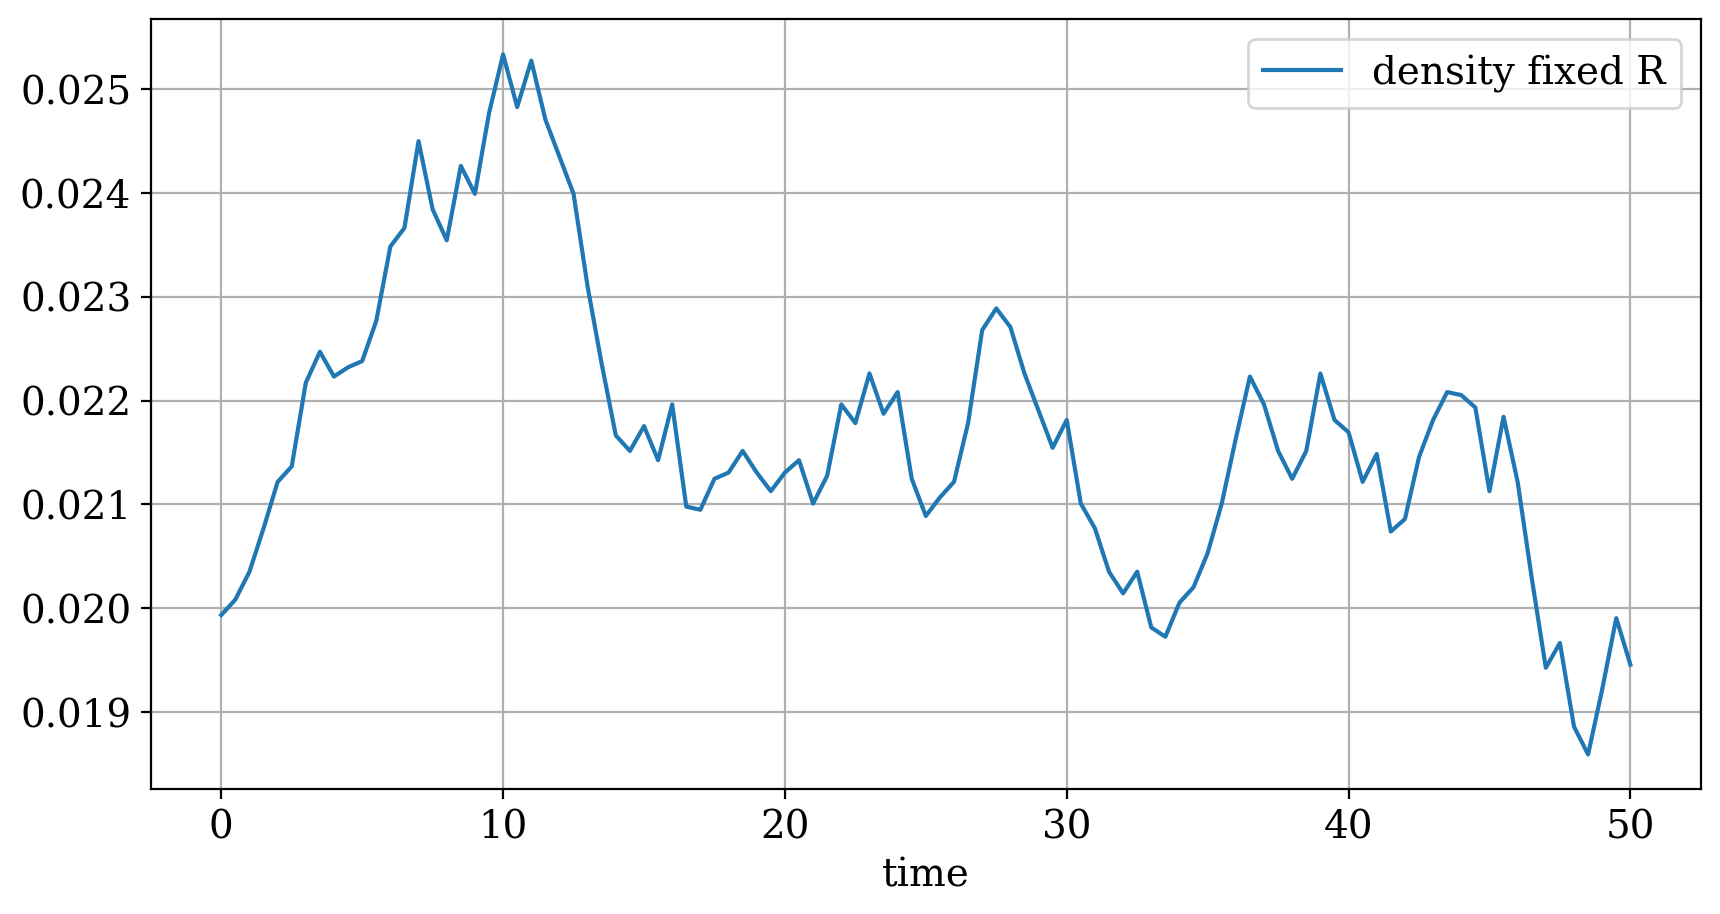

In [71]:
r_evolution = np.empty((N, n_outputs))
r_evolution = np.sqrt(x_evolution**2 + y_evolution**2 + z_evolution**2)
print(r_evolution.shape)
r_fixed = 20
density_fixed_R = []
for t in range(len(data_time)):
    density_fixed_R.append(density_fixed_t_fixed_r(r_evolution, time_index= t, fixed_R = r_fixed))

plt.plot(data_time, density_fixed_R, label = 'density fixed R')
plt.xlabel("time")
#plt.ylabel("radius")
plt.legend()
plt.grid()
#plt.show()


In [72]:
r_evolution = np.empty((N, n_outputs))
r_evolution = np.sqrt(x_evolution**2 + y_evolution**2 + z_evolution**2)
print(r_evolution.shape)
#external r for each timelapse.... NON MI CONVINCE TROPPO USARE QUESTO PER LA DENSITÀ... PERCHÈ MI PRENDE LA PARTICELLE CHE SCAPPANO
r_ext = np.max(r_evolution, axis = 0)
r_mean = np.mean(r_evolution, axis = 0)
rho_evolution = N * data_mass[1] / (4/3 * np.pi * (r_ext)**3 )
rho_evolution = N * data_mass[1] / (4/3 * np.pi * (r_mean)**3 )
'''
#plt.plot(data_time, r_ext, label = 'external radius')
plt.plot(data_time, r_mean, label = 'mean radius')
#plt.plot(data_time, rho_evolution, label = 'density')
plt.xlabel("time")
#plt.ylabel("radius")
plt.legend()
plt.grid()
#plt.show()
'''

(10001, 101)


'\n#plt.plot(data_time, r_ext, label = \'external radius\')\nplt.plot(data_time, r_mean, label = \'mean radius\')\n#plt.plot(data_time, rho_evolution, label = \'density\')\nplt.xlabel("time")\n#plt.ylabel("radius")\nplt.legend()\nplt.grid()\n#plt.show()\n'

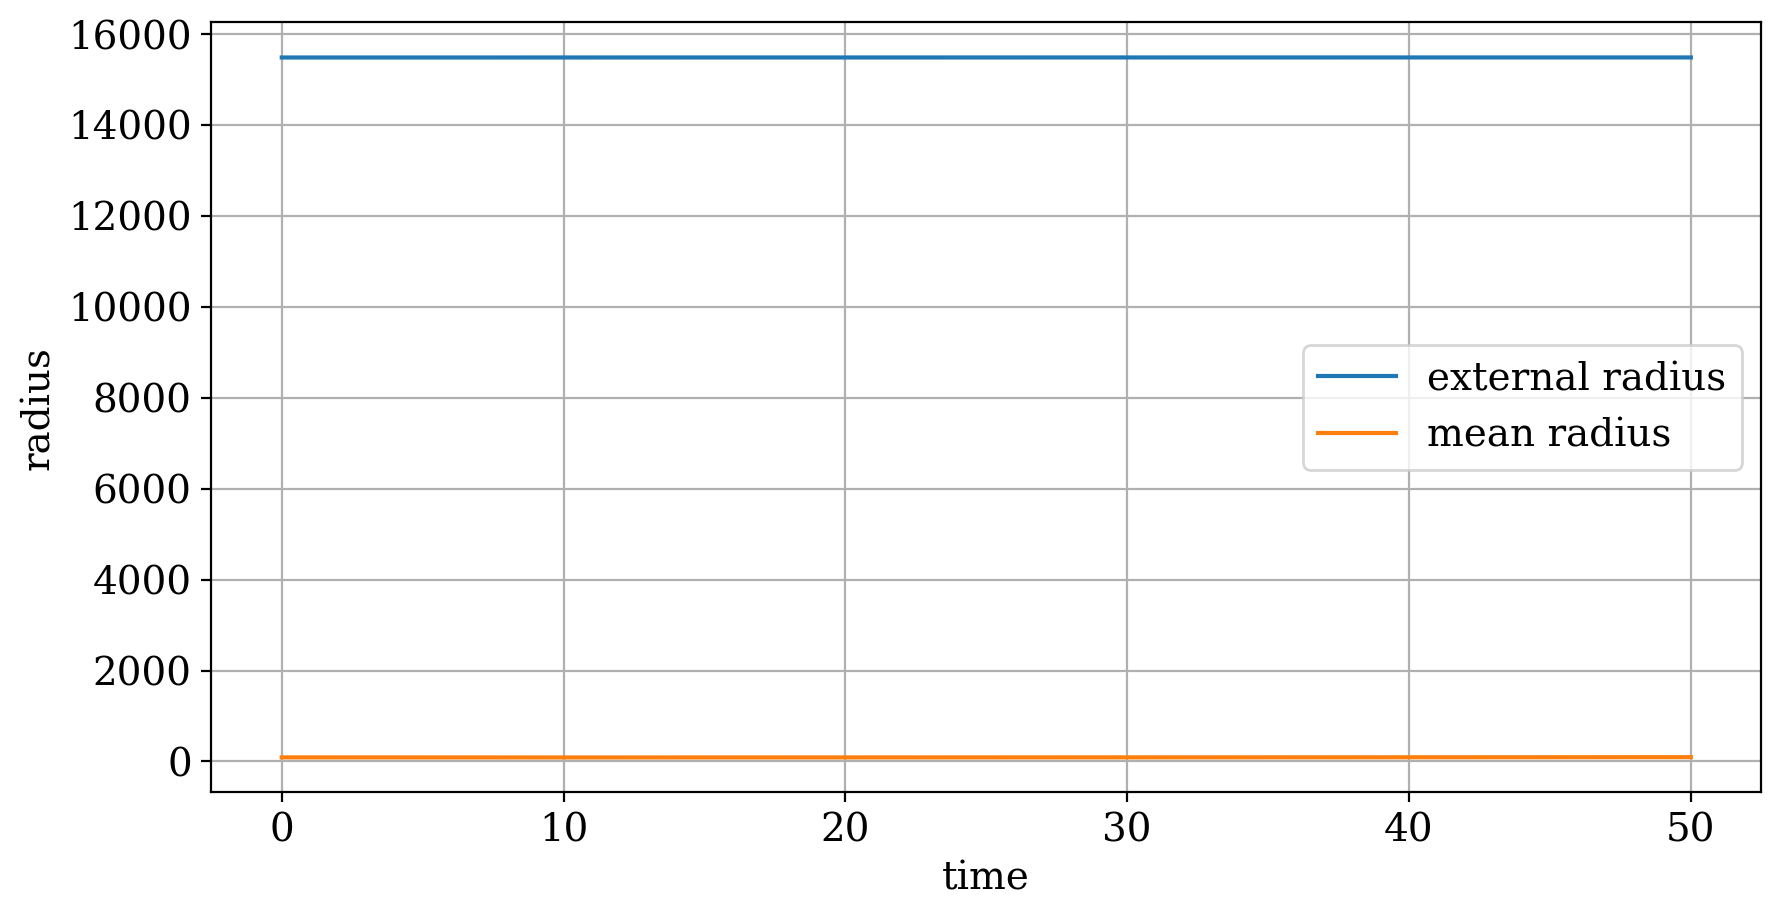

In [73]:
plt.plot(data_time, r_ext, label = 'external radius')
plt.plot(data_time, r_mean, label = 'mean radius')
plt.xlabel("time")
plt.ylabel("radius")
#plt.ylim(0,5000)
plt.legend()
plt.grid()

# Density profile

In [74]:
# ATTENZIONE CAMBIARE SE HAI CAMBIATO I PARAMETRIIIIII
radii = np.linspace(0.1, r_ext[0], 5000)
density_analytical = 3 *N*data_mass[1] / (4 * np.pi * b**3 ) * (1 / (1 + radii**2 / (scale_factor**2) ) )**(5/2)


[]
[]
[]
[]
15483.006506307005


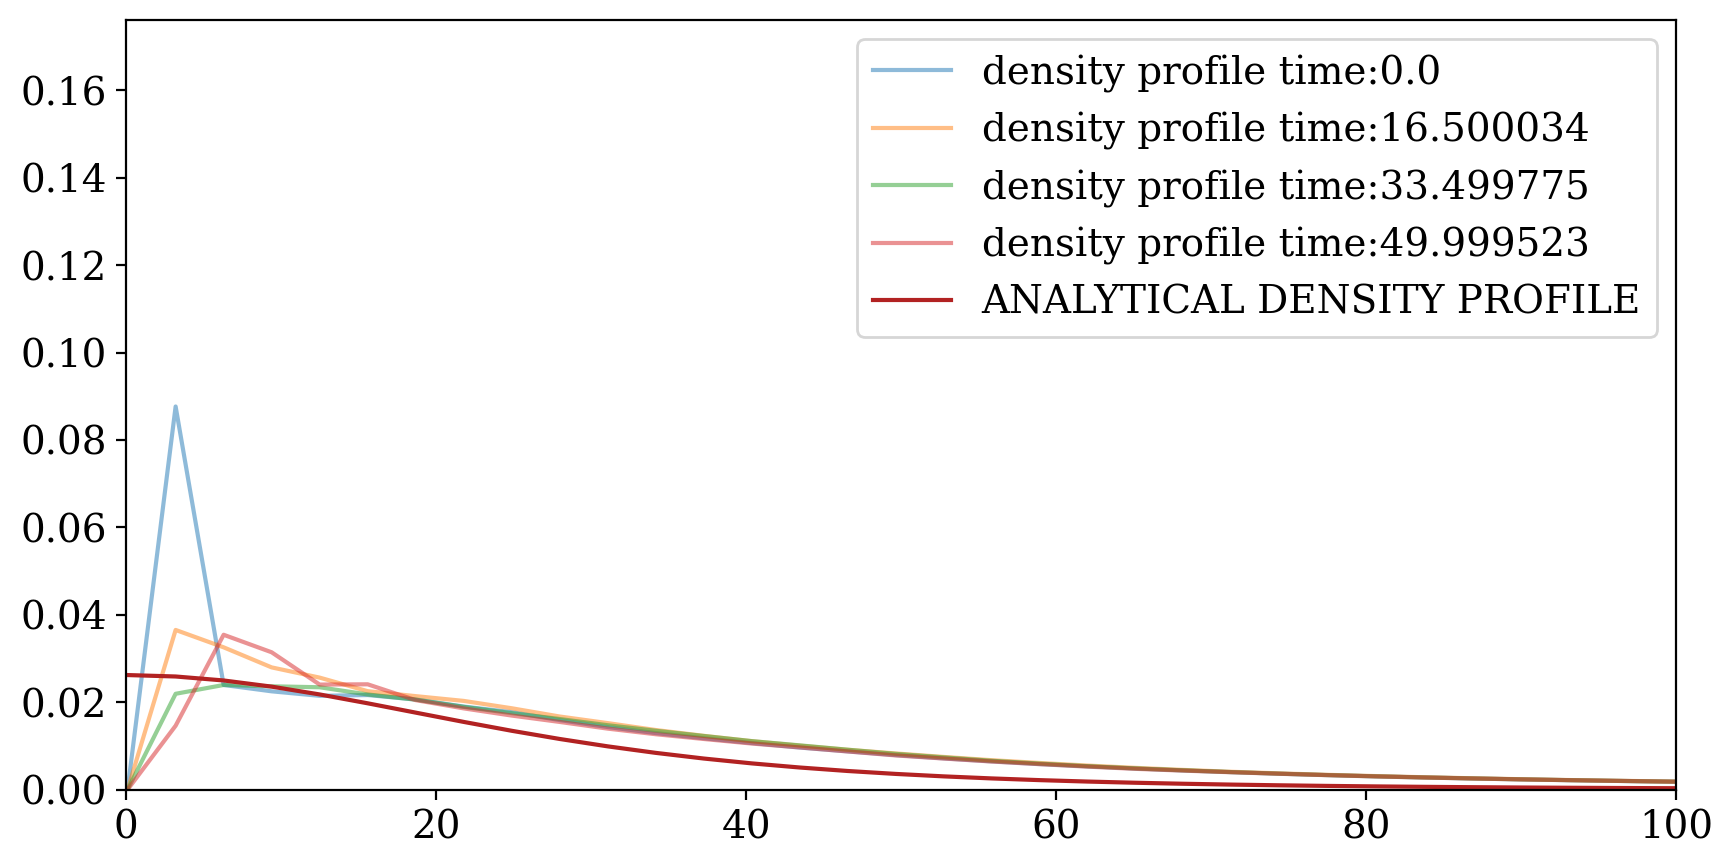

In [75]:
#let's do the first one first

time_for_dens = [0, int(len(data_time)/3), int(2*len(data_time)/3), len(data_time)-1]
for td in time_for_dens:
    density= []
    print(density)
    for R in radii:
        i = 0
        for r_p in r_evolution[:,td]:    
            if (r_p <= R):
                i = i+1
        density.append(i * data_mass[1] / (4/3 * np.pi * R**3)) 
    #plt.hist(density,int(n_bodies**0.5))
    plt.plot(radii, density, label = "density profile time:"+ str(data_time[td]), alpha = 0.5)
    
plt.plot(radii, density_analytical, c = "firebrick", label = "ANALYTICAL DENSITY PROFILE")
plt.xlim(0,100)
plt.ylim(0, np.max(density_analytical)+ 0.15)
plt.legend()
print(r_ext[0])
# we count them, so for a litte number of particles might scatter the distribution because of the poissonian error ( proportinal to sqrt(N))

# Lagrangian radius
The Lagrangian radius is the radius from the centre at which we find 80% of the entire mass of our distribution. If the sphere is stable, then this quantity should be a constant. We decided to see how close we are to the actual radius 'fixed' at the beginning. We then evaluate the absolute deviation and derive the relative error.

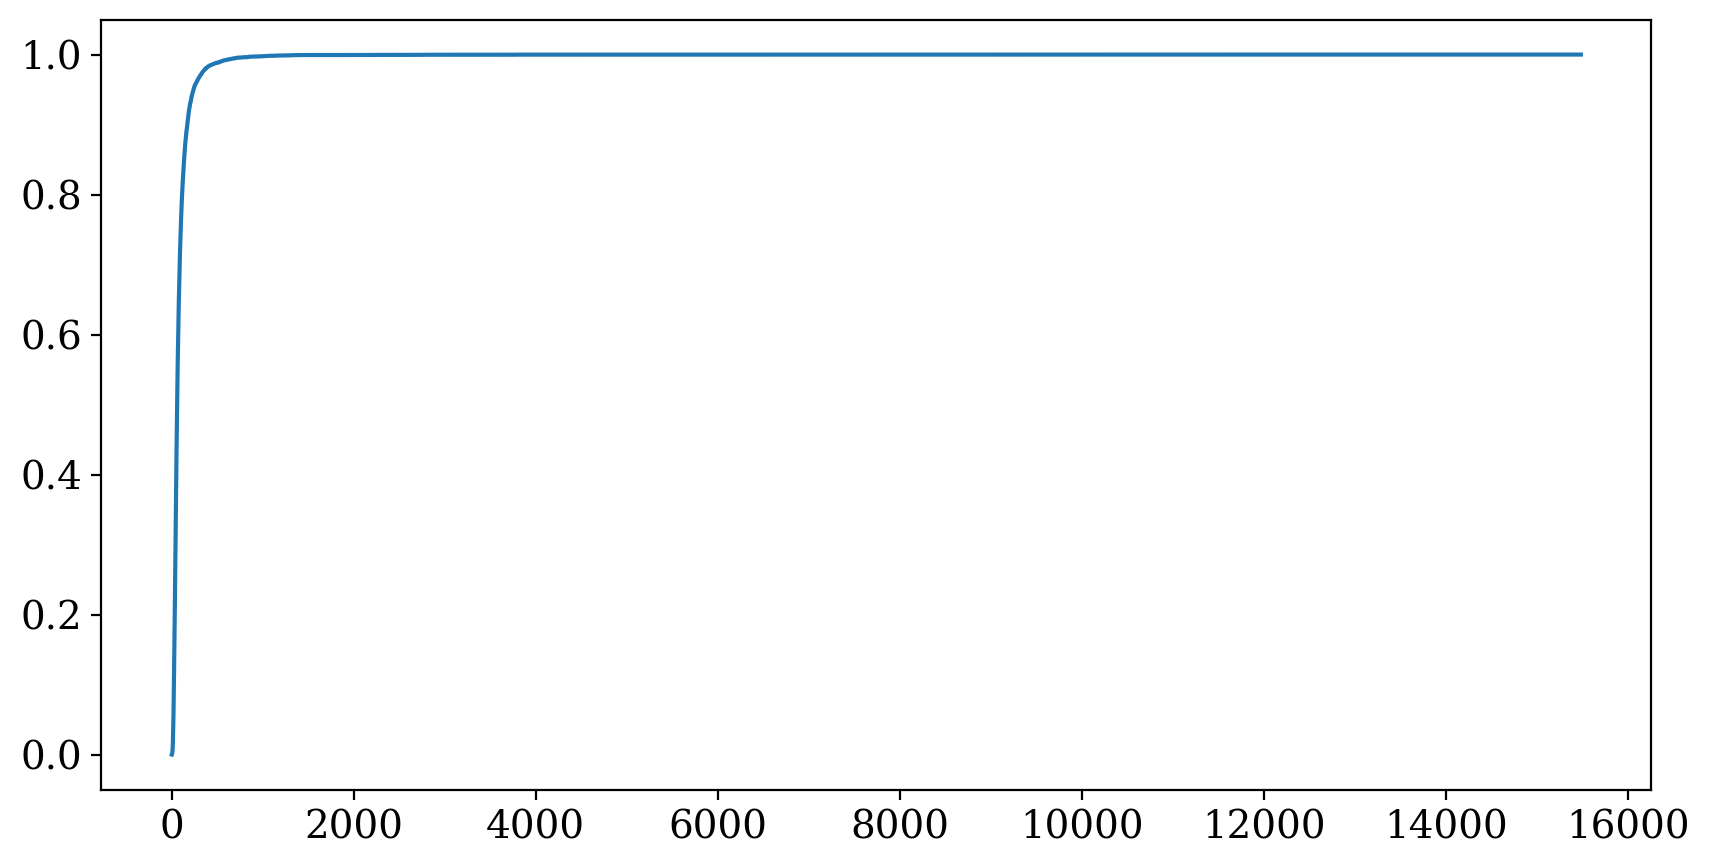

15483.006506307005


In [76]:
mass_percentage= []
for R in radii:
    i = 0
    for r_p in r_evolution[:,0]:    
        if (r_p <= R):
            i = i+1
    mass_percentage.append(i * data_mass[1] / (N*data_mass[1])) 
#plt.hist(density,int(n_bodies**0.5))
plt.show()
plt.plot(radii, mass_percentage)
#plt.xlim(0,100)

plt.show()
print(r_ext[0])

# we count them, so for a litte number of particles might scatter the distributionn because of the poissonian error ( proportinal to sqrt(N))

In [77]:

def lagrangian_radiuses_fixed_t (radii, r_evolution, time_index):
    mass_percentage= []
    lagr_02 = 0
    lagr_04 = 0
    lagr_06 = 0
    lagr_08 = 0
    
    for R in radii:
        i = 0
        for r_p in r_evolution[:,time_index]:    
            if (r_p <= R):
                i = i+1
        #print(i * data_mass[1] / (N*data_mass[1]))
        if ( ((i * data_mass[1] / (N*data_mass[1]) )> 0.1) & ((i * data_mass[1] / (N*data_mass[1]) < 0.21 )) ): 
            lagr_02 = R
        if ( ((i * data_mass[1] / (N*data_mass[1])) > 0.38) & ((i * data_mass[1] / (N*data_mass[1]) < 0.41 )) ): 
            lagr_04 = R
        if ( ((i * data_mass[1] / (N*data_mass[1])) > 0.59) & ((i * data_mass[1] / (N*data_mass[1]) < 0.61 )) ):
            lagr_06 = R
        if ( ((i * data_mass[1] / (N*data_mass[1])) > 0.79) & ((i * data_mass[1] / (N*data_mass[1]) < 0.81)) ):
            lagr_08 = R
            
    return lagr_02, lagr_04, lagr_06, lagr_08
 

In [78]:
lagr_02i, lagr_04i, lagr_06i, lagr_08i = lagrangian_radiuses_fixed_t(radii, r_evolution, time_index= 4)
print(lagr_02i, lagr_04i, lagr_06i, lagr_08i)

31.07200741409683 49.65521186255493 71.3356170524227 114.69642743215826


In [79]:
# to find the lagrangian radius from theory

def lagr_th(scale_factor, quantile): 
    rad3_cb3 = (quantile * scale_factor**3)**(1/3)
    return rad3_cb3 / (1 - 1 / scale_factor**2 * rad3_cb3**2)**(1/2)

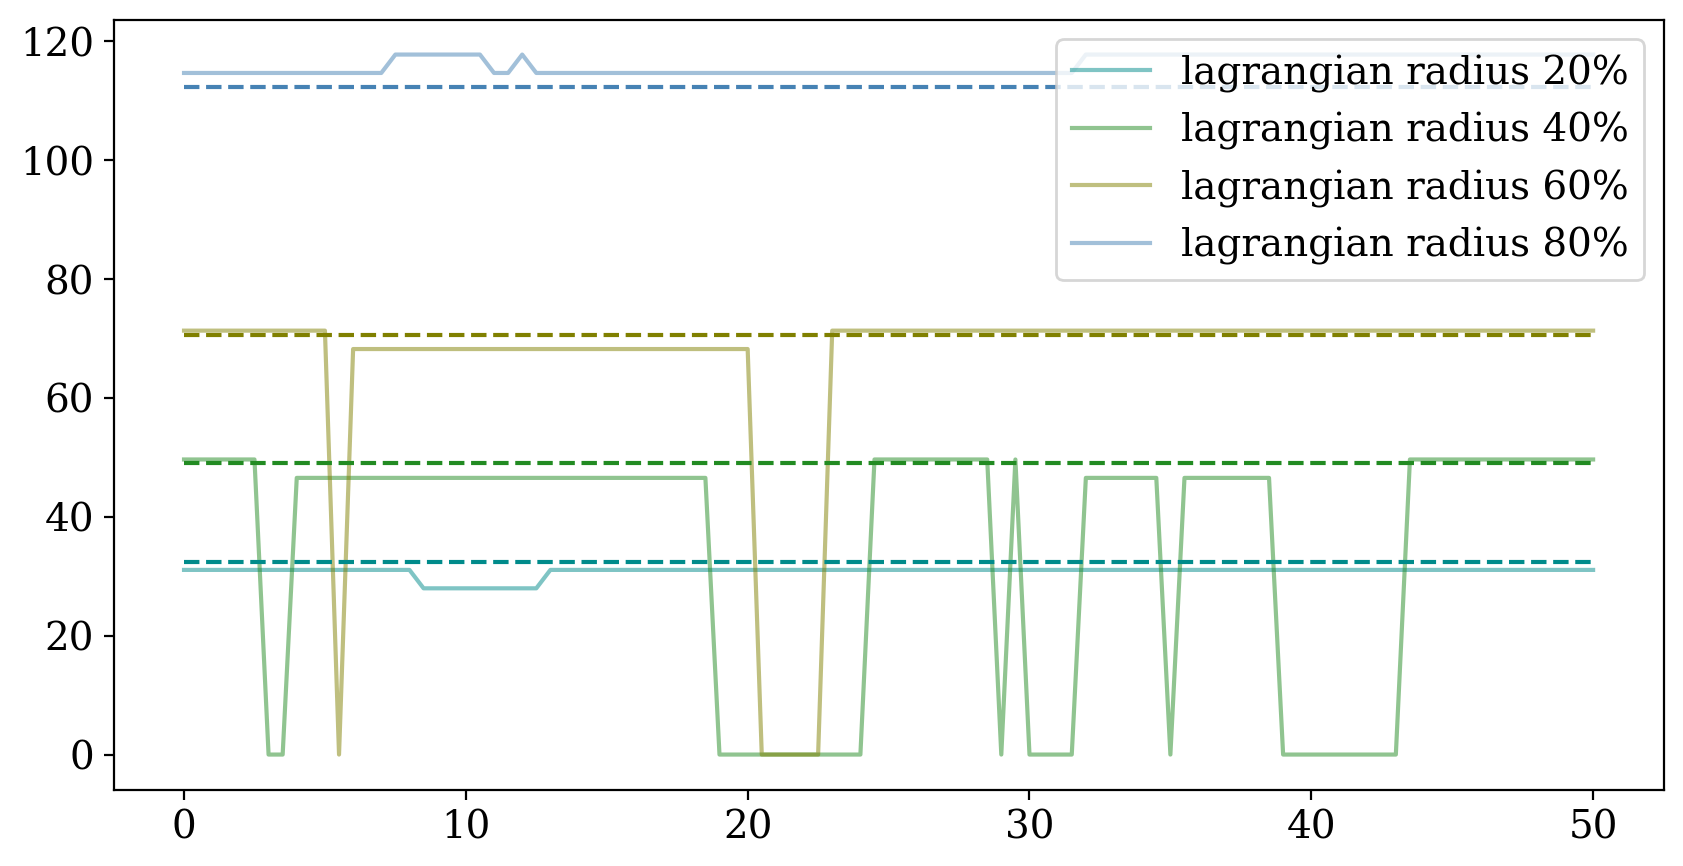

In [80]:
# let's put this in a for cycle over time and save where the mass percentace is 0.2, 0.4, 0.6, 0.8
lagr_02 = []
lagr_04 = []
lagr_06 = []
lagr_08 = []
c = ['darkcyan', 'forestgreen', 'olive', 'steelblue']
for t in range(len(data_time)):
    lagr_02i, lagr_04i, lagr_06i, lagr_08i = lagrangian_radiuses_fixed_t(radii, r_evolution, time_index= t)
    lagr_02.append(lagr_02i)
    lagr_04.append(lagr_04i)
    lagr_06.append(lagr_06i)
    lagr_08.append(lagr_08i)

plt.plot(data_time, lagr_02, label = "lagrangian radius 20%", c = c[0], alpha = 0.5)
plt.plot(data_time, lagr_04, label = "lagrangian radius 40%", c = c[1], alpha = 0.5)
plt.plot(data_time, lagr_06, label = "lagrangian radius 60%", c = c[2], alpha = 0.5)
plt.plot(data_time, lagr_08, label = "lagrangian radius 80%", c = c[3], alpha = 0.5)


for j, i in zip([0.2, 0.4, 0.6, 0.8], range(0, 4)):
    
    plt.hlines(lagr_th(scale_factor, j), 0, np.max(data_time), color=c[i], linestyle = '--')


plt.legend()
    

# cose che avevamo inserito e poi tolto


r_evolution = np.empty((N, n_outputs))
r_evolution = np.sqrt(x_evolution**2 + y_evolution**2 + z_evolution**2)
print(r_evolution.shape)
#external r for each timelapse.... NON MI CONVINCE TROPPO USARE QUESTO PER LA DENSITÀ... PERCHÈ MI PRENDE LA PARTICELLE CHE SCAPPANO


# BRAVA MALVI DEL PASSATO! CAMBIAMOLO !
max1_r_fin = np.argmax(r_evolution[:, len(data_time)-1])
print(max1_r_fin)
#The target axis is specified by the third argument axis. In this example, axis=0 targets rows.
r_evol_1 = np.delete(r_evolution, max1_r_fin, 0)

max2_r_fin = np.argmax(r_evol_1[:, len(data_time)-1])
r_evol_2 = np.delete(r_evol_1, max2_r_fin, 0)

max3_r_fin = np.argmax(r_evol_2[:, len(data_time)-1])
r_evol_3 = np.delete(r_evol_2, max3_r_fin, 0)


max4_r_fin = np.argmax(r_evol_3[:, len(data_time)-1])
r_evol_4 = np.delete(r_evol_3, max4_r_fin, 0)

print(r_evol_4.shape, max3_r_fin)

time = np.linspace(0, 0.5, n_outputs)
plt.figure(figsize=(8,6))
for i in range(N-4):
    plt.plot(time, r_evol_4[i])
plt.axvline(0.175, color='black', linestyle='dashed', label='Collapse time')
plt.xlabel('Time')
plt.ylabel('Particle radius')
plt.title('Particles Radiuses vs Time')
plt.legend()
plt.show()


#max1_r_fin = np.argmax(r_evolution[:,N])


r_ext = np.max(r_evol_4, axis = 0)
r_mean = np.mean(r_evol_4, axis = 0)
#rho_evolution = N * data_mass[1] / (4/3 * np.pi * (r_ext)**3 )
rho_evolution = N * data_mass[1] / (4/3 * np.pi * (r_mean)**3 )

#radius_casual = 40 * np.ones(len(rho_evolution))
#rho_evolution = N * data_mass[1] / (4/3 * np.pi * (radius_casual)**3 )

#plt.plot(data_time, r_ext, label = 'external radius')
#plt.plot(data_time, r_mean, label = 'mean radius')
plt.plot(data_time, rho_evolution, label = 'density calculated with mean radius')
plt.xlabel("time")
#plt.ylabel("radius")
plt.legend()
plt.grid()
#plt.show()


## oppure

In [24]:
def density_estimator(r_min, r_max, r_t): 
    
    V = 4/3 * np.pi * (r_max**3 - r_min**3)
    N_particles = len(r_t[r_t < r_max]) - len(r_t[r_t < r_min])
    M_within = N_particles * m
    
    return M_within / V


In [25]:
R = [0.1, 0.2, 0.5, 0.9, 1, 1.5, 2, 3, 4, 5]

rho_0 = []

for i in range(0, len(R) -1):
    
    rho_0.append(density_estimator(R[i], R[i+1], r_ptot))


TypeError: '<' not supported between instances of 'list' and 'float'

In [ ]:
plt.figure(figsize = (6,6))
plt.scatter(R[:-1], rho_0, c='k', label=r'initial $\rho$')
plt.plot(rs_grid, rho_theor, c='C0', label=r'theoretical $\rho$')
plt.title(r"$\rho(r)$", fontsize=16)
plt.xlabel(r"$r$", fontsize=13)
plt.ylabel(r"$\rho$", fontsize=13)
plt.legend()
plt.margins(0.05, 0.05)
plt.show()